<strong><h1>Промышленность</h1></strong>

### Содержание:

Задача проекта:<br>Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Построить модель, которая предскажет температуру стали.

### <strong>Описание этапа обработки </strong>

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

### <strong>Описание данных</strong>



Данные состоят из файлов, полученных из разных источников:

- `data_arc_new.csv` — данные об электродах;
- `data_bulk_new.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time_new.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas_new.csv` — данные о продувке сплава газом;
- `data_temp_new.csv` — результаты измерения температуры;
- `data_wire_new.csv` — данные о проволочных материалах (объём);
- `data_wire_time_new.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

### <strong>План проекта</strong>

1. Провести исследовательский анализ данных, построить графики, сделать первичные выводы на основе увиденного.
2. Провести предобработку данных. Удалить лишние строки, строки не подходящие нам по условию, заполнить пропуски, удалить аномальные значения, добавить новые признаки.
3. Провести объединение таблиц в итоговую. Проверить полученную таблицу по известным нам критериям.
4. Разбить таблицу на тестовую и тренировочную выборку.
5. Обучение моделей и подбор гиперпараметров к ним.
6. Выбор лучшей модели.
7. Проверка выбранной модели на тестовой выборке, сравнение модели с константной (проверка адекватности модели).
8. Написание итоговых выводов.
9. Составление отчета.

### <strong>Цель:</strong>

Построить модель, которая предскажет температуру стали.

### Загрузка библиотек

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np
import re 

random_state = 220523
pd.options.display.max_columns = None 
import warnings
warnings.filterwarnings('ignore')

In [8]:
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.dummy import DummyRegressor
from sklearn.feature_selection import chi2 
from time import time

from sklearn.utils import shuffle

In [9]:
data_arc = pd.read_csv('/datasets/data_arc_new.csv')
data_bulk = pd.read_csv('/datasets/data_bulk_new.csv')
data_bulk_time = pd.read_csv('/datasets/data_bulk_time_new.csv')
data_gas = pd.read_csv('/datasets/data_gas_new.csv')
data_temp = pd.read_csv('/datasets/data_temp_new.csv')
data_wire = pd.read_csv('/datasets/data_wire_new.csv')
data_wire_time = pd.read_csv('/datasets/data_wire_time_new.csv')

### Исследовательский анализ данных

In [10]:
all_datas = {
    'Данные об электродах':data_arc, 
    'Данные о подаче сыпучих материалов (объём)':data_bulk, 
    'Данные о подаче сыпучих материалов (время)':data_bulk_time,
    'Данные о продувке сплава газом':data_gas,
    'Результаты измерения температуры':data_temp,
    'Данные о проволочных материалах (объём)':data_wire,
    'Данные о проволочных материалах (время)':data_wire_time
}

In [11]:
for i in all_datas:
    print()
    print(i)
    print()
    print('Размерность :', all_datas[i].shape)
    print()
    display(all_datas[i].info())
    print()
    display(all_datas[i].describe(include='all').T)
    print()
    display('Кол-во дубликатов:', all_datas[i].duplicated().sum())
    print()
    display('Кол-во пропусков:',all_datas[i].isnull().sum())
    print()
    display('Колонки :',all_datas[i].columns.to_list)
    print()
    display(all_datas[i].head(10))
    print('-')
    print("---")
    print('-')


Данные об электродах

Размерность : (14876, 5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None

count unique                  top freq         mean  \
key                   14876.0    NaN                  NaN  NaN  1615.220422   
Начало нагрева дугой    14876  14876  2019-05-06 13:17:59    1          NaN   
Конец нагрева дугой     14876  14876  2019-09-04 11:20:41    1          NaN   
Активная мощность     14876.0    NaN                  NaN  NaN     0.662752   
Реактивная мощность   14876.0    NaN                  NaN  NaN     0.438986   

                             std         min       25%       50%       75%  \
key                   934.571502         1.0     806.0    1617.0    2429.0   
Начало нагрева дугой         NaN         NaN       NaN       NaN       NaN   
Конец нагрева дугой          NaN         NaN       NaN       NaN       NaN   
Активная мощность       0.258885     0.22312  0.467115  0.599587   0.83007   
Реактивная мощность     5.873485 -715.479924  0.337175  0.441639  0.608201   

                           max  
key                     3241.0  
Начало нагрева дугой       NaN  
Конец нагрева дугой        NaN  
Активная мощность     1.463773  
Реактивная мощность   1.270284

'Кол-во дубликатов:'

0

'Кол-во пропусков:'

key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64

'Колонки :'

<bound method IndexOpsMixin.tolist of Index(['key', 'Начало нагрева дугой', 'Конец нагрева дугой',
       'Активная мощность', 'Реактивная мощность'],
      dtype='object')>

key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
0    1  2019-05-03 11:02:14  2019-05-03 11:06:02           0.305130   
1    1  2019-05-03 11:07:28  2019-05-03 11:10:33           0.765658   
2    1  2019-05-03 11:11:44  2019-05-03 11:14:36           0.580313   
3    1  2019-05-03 11:18:14  2019-05-03 11:24:19           0.518496   
4    1  2019-05-03 11:26:09  2019-05-03 11:28:37           0.867133   
5    2  2019-05-03 11:34:14  2019-05-03 11:36:31           0.381124   
6    2  2019-05-03 11:38:50  2019-05-03 11:44:28           0.261665   
7    2  2019-05-03 11:46:19  2019-05-03 11:48:25           0.710297   
8    2  2019-05-03 11:49:48  2019-05-03 11:53:18           0.786322   
9    3  2019-05-03 12:06:54  2019-05-03 12:11:34           1.101678   

   Реактивная мощность  
0             0.211253  
1             0.477438  
2             0.430460  
3             0.379979  
4             0.643691  
5             0.220351  
6             0.205527  
7             0.484962  
8             0.542517  
9             0.820856

-
---
-

Данные о подаче сыпучих материалов (объём)

Размерность : (3129, 16)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

count         mean         std    min     25%     50%      75%  \
key      3129.0  1624.383509  933.337642    1.0  816.00  1622.0  2431.00   
Bulk 1    252.0    39.242063   18.277654   10.0   27.00    31.0    46.00   
Bulk 2     22.0   253.045455   21.180578  228.0  242.00   251.5   257.75   
Bulk 3   1298.0   113.879045   75.483494    6.0   58.00    97.5   152.00   
Bulk 4   1014.0   104.394477   48.184126   12.0   72.00   102.0   133.00   
Bulk 5     77.0   107.025974   81.790646   11.0   70.00    86.0   132.00   
Bulk 6    576.0   118.925347   72.057776   17.0   69.75   100.0   157.00   
Bulk 7     25.0   305.600000  191.022904   47.0  155.00   298.0   406.00   
Bulk 8      1.0    49.000000         NaN   49.0   49.00    49.0    49.00   
Bulk 9     19.0    76.315789   21.720581   63.0   66.00    68.0    70.50   
Bulk 10   176.0    83.284091   26.060347   24.0   64.00    86.5   102.00   
Bulk 11   177.0    76.819209   59.655365    8.0   25.00    64.0   106.00   
Bulk 12  2450.0   260.471020  120.649269   53.0  204.00   208.0   316.00   
Bulk 13    18.0   181.111111   46.088009  151.0  153.25   155.5   203.50   
Bulk 14  2806.0   170.284747   65.868652   16.0  119.00   151.0   205.75   
Bulk 15  2248.0   160.513345   51.765319    1.0  105.00   160.0   205.00   

            max  
key      3241.0  
Bulk 1    185.0  
Bulk 2    325.0  
Bulk 3    454.0  
Bulk 4    281.0  
Bulk 5    603.0  
Bulk 6    503.0  
Bulk 7    772.0  
Bulk 8     49.0  
Bulk 9    147.0  
Bulk 10   159.0  
Bulk 11   313.0  
Bulk 12  1849.0  
Bulk 13   305.0  
Bulk 14   636.0  
Bulk 15   405.0

'Кол-во дубликатов:'

0

'Кол-во пропусков:'

key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

'Колонки :'

<bound method IndexOpsMixin.tolist of Index(['key', 'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6',
       'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12',
       'Bulk 13', 'Bulk 14', 'Bulk 15'],
      dtype='object')>

key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
0    1     NaN     NaN     NaN    43.0     NaN     NaN     NaN     NaN   
1    2     NaN     NaN     NaN    73.0     NaN     NaN     NaN     NaN   
2    3     NaN     NaN     NaN    34.0     NaN     NaN     NaN     NaN   
3    4     NaN     NaN     NaN    81.0     NaN     NaN     NaN     NaN   
4    5     NaN     NaN     NaN    78.0     NaN     NaN     NaN     NaN   
5    6     NaN     NaN     NaN   117.0     NaN     NaN     NaN     NaN   
6    7     NaN     NaN     NaN   117.0     NaN     NaN     NaN     NaN   
7    8     NaN     NaN     NaN    99.0     NaN     NaN     NaN     NaN   
8    9     NaN     NaN     NaN   117.0     NaN     NaN     NaN     NaN   
9   10     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

   Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
0     NaN      NaN      NaN    206.0      NaN    150.0    154.0  
1     NaN      NaN      NaN    206.0      NaN    149.0    154.0  
2     NaN      NaN      NaN    205.0      NaN    152.0    153.0  
3     NaN      NaN      NaN    207.0      NaN    153.0    154.0  
4     NaN      NaN      NaN    203.0      NaN    151.0    152.0  
5     NaN      NaN      NaN    204.0      NaN    201.0    154.0  
6     NaN      NaN      NaN    204.0      NaN    152.0    154.0  
7     NaN      NaN      NaN    410.0      NaN    252.0    153.0  
8     NaN      NaN      NaN    107.0      NaN     99.0    203.0  
9     NaN      NaN      NaN    203.0      NaN    102.0    204.0

-
---
-

Данные о подаче сыпучих материалов (время)

Размерность : (3129, 16)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


None

count unique                  top freq         mean         std  \
key      3129.0    NaN                  NaN  NaN  1624.383509  933.337642   
Bulk 1      252    252  2019-05-20 08:58:33    1          NaN         NaN   
Bulk 2       22     22  2019-05-07 15:39:35    1          NaN         NaN   
Bulk 3     1298   1298  2019-08-20 07:32:56    1          NaN         NaN   
Bulk 4     1014   1014  2019-06-19 08:05:23    1          NaN         NaN   
Bulk 5       77     77  2019-07-04 14:00:31    1          NaN         NaN   
Bulk 6      576    576  2019-06-25 13:49:21    1          NaN         NaN   
Bulk 7       25     25  2019-09-05 19:07:49    1          NaN         NaN   
Bulk 8        1      1  2019-07-08 17:14:53    1          NaN         NaN   
Bulk 9       19     19  2019-05-14 13:02:53    1          NaN         NaN   
Bulk 10     176    176  2019-06-01 00:59:53    1          NaN         NaN   
Bulk 11     177    177  2019-06-15 17:46:40    1          NaN         NaN   
Bulk 12    2450   2450  2019-08-13 19:43:11    1          NaN         NaN   
Bulk 13      18     18  2019-05-05 02:10:21    1          NaN         NaN   
Bulk 14    2806   2806  2019-05-18 02:14:36    1          NaN         NaN   
Bulk 15    2248   2248  2019-06-19 08:05:23    1          NaN         NaN   

         min    25%     50%     75%     max  
key      1.0  816.0  1622.0  2431.0  3241.0  
Bulk 1   NaN    NaN     NaN     NaN     NaN  
Bulk 2   NaN    NaN     NaN     NaN     NaN  
Bulk 3   NaN    NaN     NaN     NaN     NaN  
Bulk 4   NaN    NaN     NaN     NaN     NaN  
Bulk 5   NaN    NaN     NaN     NaN     NaN  
Bulk 6   NaN    NaN     NaN     NaN     NaN  
Bulk 7   NaN    NaN     NaN     NaN     NaN  
Bulk 8   NaN    NaN     NaN     NaN     NaN  
Bulk 9   NaN    NaN     NaN     NaN     NaN  
Bulk 10  NaN    NaN     NaN     NaN     NaN  
Bulk 11  NaN    NaN     NaN     NaN     NaN  
Bulk 12  NaN    NaN     NaN     NaN     NaN  
Bulk 13  NaN    NaN     NaN     NaN     NaN  
Bulk 14  NaN    NaN     NaN     NaN     NaN  
Bulk 15  NaN    NaN     NaN     NaN     NaN

'Кол-во дубликатов:'

0

'Кол-во пропусков:'

key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

'Колонки :'

<bound method IndexOpsMixin.tolist of Index(['key', 'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6',
       'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12',
       'Bulk 13', 'Bulk 14', 'Bulk 15'],
      dtype='object')>

key Bulk 1 Bulk 2 Bulk 3               Bulk 4 Bulk 5 Bulk 6 Bulk 7 Bulk 8  \
0    1    NaN    NaN    NaN  2019-05-03 11:28:48    NaN    NaN    NaN    NaN   
1    2    NaN    NaN    NaN  2019-05-03 11:36:50    NaN    NaN    NaN    NaN   
2    3    NaN    NaN    NaN  2019-05-03 12:32:39    NaN    NaN    NaN    NaN   
3    4    NaN    NaN    NaN  2019-05-03 12:43:22    NaN    NaN    NaN    NaN   
4    5    NaN    NaN    NaN  2019-05-03 13:30:47    NaN    NaN    NaN    NaN   
5    6    NaN    NaN    NaN  2019-05-03 13:57:27    NaN    NaN    NaN    NaN   
6    7    NaN    NaN    NaN  2019-05-03 14:18:58    NaN    NaN    NaN    NaN   
7    8    NaN    NaN    NaN  2019-05-03 15:17:58    NaN    NaN    NaN    NaN   
8    9    NaN    NaN    NaN  2019-05-03 16:03:08    NaN    NaN    NaN    NaN   
9   10    NaN    NaN    NaN                  NaN    NaN    NaN    NaN    NaN   

  Bulk 9 Bulk 10 Bulk 11              Bulk 12 Bulk 13              Bulk 14  \
0    NaN     NaN     NaN  2019-05-03 11:24:31     NaN  2019-05-03 11:14:50   
1    NaN     NaN     NaN  2019-05-03 11:53:30     NaN  2019-05-03 11:48:37   
2    NaN     NaN     NaN  2019-05-03 12:27:13     NaN  2019-05-03 12:21:01   
3    NaN     NaN     NaN  2019-05-03 12:58:00     NaN  2019-05-03 12:51:11   
4    NaN     NaN     NaN  2019-05-03 13:30:47     NaN  2019-05-03 13:34:12   
5    NaN     NaN     NaN  2019-05-03 13:48:52     NaN  2019-05-03 14:09:42   
6    NaN     NaN     NaN  2019-05-03 14:41:26     NaN  2019-05-03 14:30:50   
7    NaN     NaN     NaN  2019-05-03 15:17:58     NaN  2019-05-03 15:13:18   
8    NaN     NaN     NaN  2019-05-03 16:03:08     NaN  2019-05-03 16:00:16   
9    NaN     NaN     NaN  2019-05-03 16:38:11     NaN  2019-05-03 16:34:24   

               Bulk 15  
0  2019-05-03 11:10:43  
1  2019-05-03 11:44:39  
2  2019-05-03 12:16:16  
3  2019-05-03 12:46:36  
4  2019-05-03 13:30:47  
5  2019-05-03 14:03:15  
6  2019-05-03 14:27:16  
7  2019-05-03 15:05:33  
8  2019-05-03 15:52:39  
9  2019-05-03 16:29:56

-
---
-

Данные о продувке сплава газом

Размерность : (3239, 2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

count         mean         std       min         25%          50%  \
key    3239.0  1621.861377  935.386334  1.000000  812.500000  1622.000000   
Газ 1  3239.0    11.002062    6.220327  0.008399    7.043089     9.836267   

               75%         max  
key    2431.500000  3241.00000  
Газ 1    13.769915    77.99504

'Кол-во дубликатов:'

0

'Кол-во пропусков:'

key      0
Газ 1    0
dtype: int64

'Колонки :'

<bound method IndexOpsMixin.tolist of Index(['key', 'Газ 1'], dtype='object')>

key      Газ 1
0    1  29.749986
1    2  12.555561
2    3  28.554793
3    4  18.841219
4    5   5.413692
5    6  11.273392
6    7   9.836267
7    8  15.171553
8    9   8.216623
9   10   6.529891

-
---
-

Результаты измерения температуры

Размерность : (18092, 3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


None

count unique                  top freq         mean  \
key           18092.0    NaN                  NaN  NaN  1616.460977   
Время замера    18092  18092  2019-06-28 23:15:39    1          NaN   
Температура   14665.0    NaN                  NaN  NaN  1590.722741   

                     std     min     25%     50%     75%     max  
key           934.641385     1.0  807.75  1618.0  2429.0  3241.0  
Время замера         NaN     NaN     NaN     NaN     NaN     NaN  
Температура    20.394381  1191.0  1580.0  1590.0  1599.0  1705.0

'Кол-во дубликатов:'

0

'Кол-во пропусков:'

key                0
Время замера       0
Температура     3427
dtype: int64

'Колонки :'

<bound method IndexOpsMixin.tolist of Index(['key', 'Время замера', 'Температура'], dtype='object')>

key         Время замера  Температура
0    1  2019-05-03 11:02:04       1571.0
1    1  2019-05-03 11:07:18       1604.0
2    1  2019-05-03 11:11:34       1618.0
3    1  2019-05-03 11:18:04       1601.0
4    1  2019-05-03 11:25:59       1606.0
5    1  2019-05-03 11:30:38       1613.0
6    2  2019-05-03 11:34:04       1581.0
7    2  2019-05-03 11:38:40       1577.0
8    2  2019-05-03 11:46:09       1589.0
9    2  2019-05-03 11:49:38       1604.0

-
---
-

Данные о проволочных материалах (объём)

Размерность : (3081, 10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

count         mean         std        min         25%          50%  \
key     3081.0  1623.426485  932.996726   1.000000  823.000000  1619.000000   
Wire 1  3055.0   100.895853   42.012518   1.918800   72.115684   100.158234   
Wire 2  1079.0    50.577323   39.320216   0.030160   20.193680    40.142956   
Wire 3    63.0   189.482681   99.513444   0.144144   95.135044   235.194977   
Wire 4    14.0    57.442841   28.824667  24.148801   40.807002    45.234282   
Wire 5     1.0    15.132000         NaN  15.132000   15.132000    15.132000   
Wire 6    73.0    48.016974   33.919845   0.034320   25.053600    42.076324   
Wire 7    11.0    10.039007    8.610584   0.234208    6.762756     9.017009   
Wire 8    19.0    53.625193   16.881728  45.076721   46.094879    46.279999   
Wire 9    29.0    34.155752   19.931616   4.622800   22.058401    30.066399   

                75%          max  
key     2434.000000  3241.000000  
Wire 1   126.060483   330.314424  
Wire 2    70.227558   282.780152  
Wire 3   276.252014   385.008668  
Wire 4    76.124619   113.231044  
Wire 5    15.132000    15.132000  
Wire 6    64.212723   180.454575  
Wire 7    11.886057    32.847674  
Wire 8    48.089603   102.762401  
Wire 9    43.862003    90.053604

'Кол-во дубликатов:'

0

'Кол-во пропусков:'

key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

'Колонки :'

<bound method IndexOpsMixin.tolist of Index(['key', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6',
       'Wire 7', 'Wire 8', 'Wire 9'],
      dtype='object')>

key      Wire 1     Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  \
0    1   60.059998        NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1    2   96.052315        NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2    3   91.160157        NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3    4   89.063515        NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4    5   89.238236   9.114560     NaN     NaN     NaN     NaN     NaN     NaN   
5    6   99.109917   9.114560     NaN     NaN     NaN     NaN     NaN     NaN   
6    7   98.061600        NaN     NaN     NaN     NaN     NaN     NaN     NaN   
7    8  155.282394        NaN     NaN     NaN     NaN     NaN     NaN     NaN   
8    9  113.393279   9.143681     NaN     NaN     NaN     NaN     NaN     NaN   
9   10   81.244796  12.376000     NaN     NaN     NaN     NaN     NaN     NaN   

   Wire 9  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN  
5     NaN  
6     NaN  
7     NaN  
8     NaN  
9     NaN

-
---
-

Данные о проволочных материалах (время)

Размерность : (3081, 10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


None

count unique                  top freq         mean         std  min  \
key     3081.0    NaN                  NaN  NaN  1623.426485  932.996726  1.0   
Wire 1    3055   3055  2019-07-09 22:10:51    1          NaN         NaN  NaN   
Wire 2    1079   1079  2019-05-25 09:51:04    1          NaN         NaN  NaN   
Wire 3      63     63  2019-08-10 19:15:17    1          NaN         NaN  NaN   
Wire 4      14     14  2019-08-12 19:51:09    1          NaN         NaN  NaN   
Wire 5       1      1  2019-08-13 06:14:30    1          NaN         NaN  NaN   
Wire 6      73     73  2019-07-28 15:57:59    1          NaN         NaN  NaN   
Wire 7      11     11  2019-07-27 13:43:32    1          NaN         NaN  NaN   
Wire 8      19     19  2019-05-14 12:18:01    1          NaN         NaN  NaN   
Wire 9      29     29  2019-06-09 11:01:10    1          NaN         NaN  NaN   

          25%     50%     75%     max  
key     823.0  1619.0  2434.0  3241.0  
Wire 1    NaN     NaN     NaN     NaN  
Wire 2    NaN     NaN     NaN     NaN  
Wire 3    NaN     NaN     NaN     NaN  
Wire 4    NaN     NaN     NaN     NaN  
Wire 5    NaN     NaN     NaN     NaN  
Wire 6    NaN     NaN     NaN     NaN  
Wire 7    NaN     NaN     NaN     NaN  
Wire 8    NaN     NaN     NaN     NaN  
Wire 9    NaN     NaN     NaN     NaN

'Кол-во дубликатов:'

0

'Кол-во пропусков:'

key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

'Колонки :'

<bound method IndexOpsMixin.tolist of Index(['key', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6',
       'Wire 7', 'Wire 8', 'Wire 9'],
      dtype='object')>

key               Wire 1               Wire 2 Wire 3 Wire 4 Wire 5 Wire 6  \
0    1  2019-05-03 11:06:19                  NaN    NaN    NaN    NaN    NaN   
1    2  2019-05-03 11:36:50                  NaN    NaN    NaN    NaN    NaN   
2    3  2019-05-03 12:11:46                  NaN    NaN    NaN    NaN    NaN   
3    4  2019-05-03 12:43:22                  NaN    NaN    NaN    NaN    NaN   
4    5  2019-05-03 13:20:44  2019-05-03 13:15:34    NaN    NaN    NaN    NaN   
5    6  2019-05-03 13:57:27  2019-05-03 13:48:52    NaN    NaN    NaN    NaN   
6    7  2019-05-03 14:18:58                  NaN    NaN    NaN    NaN    NaN   
7    8  2019-05-03 15:01:30                  NaN    NaN    NaN    NaN    NaN   
8    9  2019-05-03 15:45:44  2019-05-03 15:39:37    NaN    NaN    NaN    NaN   
9   10  2019-05-03 16:27:00  2019-05-03 16:22:36    NaN    NaN    NaN    NaN   

  Wire 7 Wire 8 Wire 9  
0    NaN    NaN    NaN  
1    NaN    NaN    NaN  
2    NaN    NaN    NaN  
3    NaN    NaN    NaN  
4    NaN    NaN    NaN  
5    NaN    NaN    NaN  
6    NaN    NaN    NaN  
7    NaN    NaN    NaN  
8    NaN    NaN    NaN  
9    NaN    NaN    NaN

-
---
-


#### Рассмотрение графиков

Посмотрим данные на графиках:

##### Данные об электродах

In [12]:
data_arc

key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
0         1  2019-05-03 11:02:14  2019-05-03 11:06:02           0.305130   
1         1  2019-05-03 11:07:28  2019-05-03 11:10:33           0.765658   
2         1  2019-05-03 11:11:44  2019-05-03 11:14:36           0.580313   
3         1  2019-05-03 11:18:14  2019-05-03 11:24:19           0.518496   
4         1  2019-05-03 11:26:09  2019-05-03 11:28:37           0.867133   
...     ...                  ...                  ...                ...   
14871  3241  2019-09-06 16:49:05  2019-09-06 16:51:42           0.439735   
14872  3241  2019-09-06 16:55:11  2019-09-06 16:58:11           0.646498   
14873  3241  2019-09-06 17:06:48  2019-09-06 17:09:52           1.039726   
14874  3241  2019-09-06 17:21:58  2019-09-06 17:22:55           0.530267   
14875  3241  2019-09-06 17:24:54  2019-09-06 17:26:15           0.389057   

       Реактивная мощность  
0                 0.211253  
1                 0.477438  
2                 0.430460  
3                 0.379979  
4                 0.643691  
...                    ...  
14871             0.299579  
14872             0.458240  
14873             0.769302  
14874             0.361543  
14875             0.251347  

[14876 rows x 5 columns]

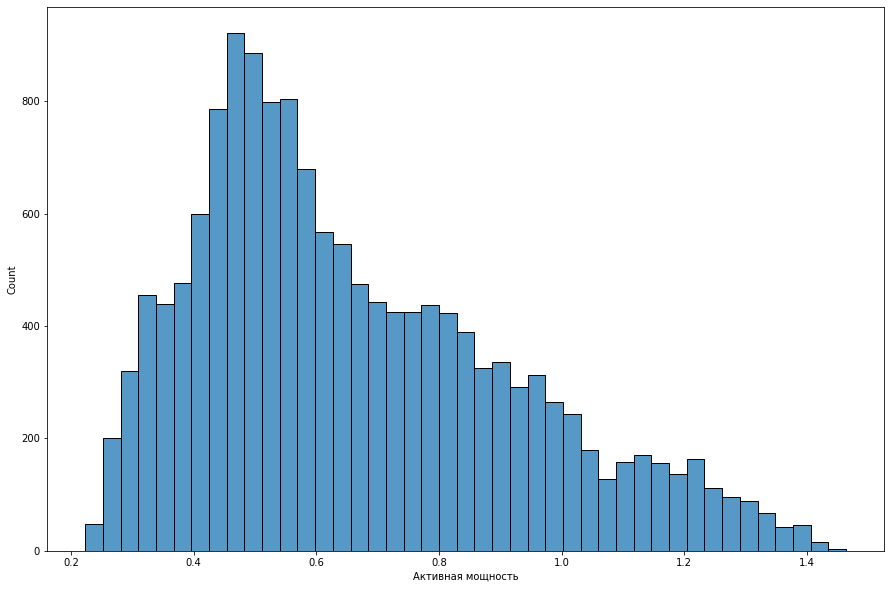

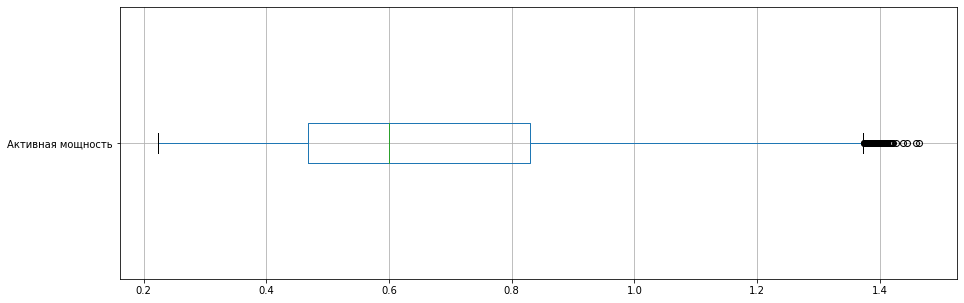

In [13]:
plt.figure(figsize=(15,10))
sns.histplot(data_arc['Активная мощность'])
plt.figure(figsize=(15, 5))
data_arc.boxplot('Активная мощность', vert=False)
plt.show()

Реактивная мощность

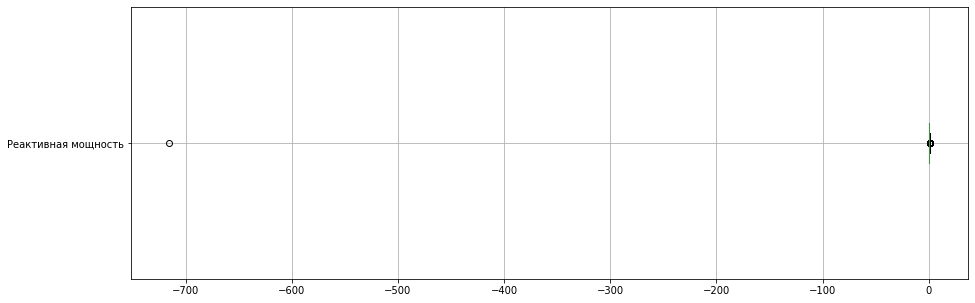

In [14]:
plt.figure(figsize=(15, 5))
data_arc.boxplot('Реактивная мощность', vert=False)
plt.show()

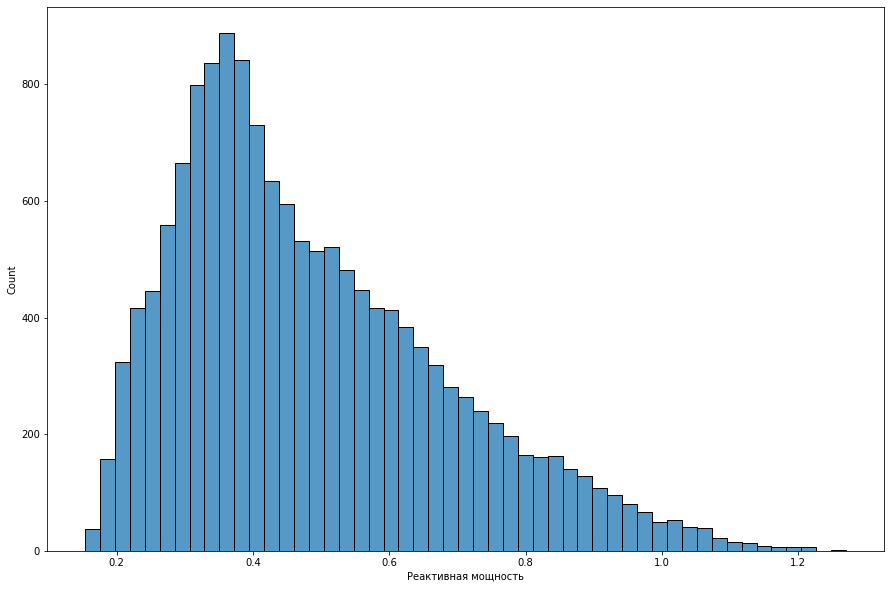

In [15]:
plt.figure(figsize=(15,10))
sns.histplot(data_arc[data_arc['Реактивная мощность'] > 0]['Реактивная мощность'])
plt.show()

In [16]:
data_arc[data_arc['Реактивная мощность'] < 0]

key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
9780  2116  2019-07-28 02:22:08  2019-07-28 02:23:57           0.705344   

      Реактивная мощность  
9780          -715.479924

Значения меньше 0 явно выброс их нужно будет убрать

##### Данные о подаче сыпучих материалов (объём)

In [17]:
data_bulk

key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
0        1     NaN     NaN     NaN    43.0     NaN     NaN     NaN     NaN   
1        2     NaN     NaN     NaN    73.0     NaN     NaN     NaN     NaN   
2        3     NaN     NaN     NaN    34.0     NaN     NaN     NaN     NaN   
3        4     NaN     NaN     NaN    81.0     NaN     NaN     NaN     NaN   
4        5     NaN     NaN     NaN    78.0     NaN     NaN     NaN     NaN   
...    ...     ...     ...     ...     ...     ...     ...     ...     ...   
3124  3237     NaN     NaN   170.0     NaN     NaN     NaN     NaN     NaN   
3125  3238     NaN     NaN   126.0     NaN     NaN     NaN     NaN     NaN   
3126  3239     NaN     NaN     NaN     NaN     NaN   114.0     NaN     NaN   
3127  3240     NaN     NaN     NaN     NaN     NaN    26.0     NaN     NaN   
3128  3241     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

      Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
0        NaN      NaN      NaN    206.0      NaN    150.0    154.0  
1        NaN      NaN      NaN    206.0      NaN    149.0    154.0  
2        NaN      NaN      NaN    205.0      NaN    152.0    153.0  
3        NaN      NaN      NaN    207.0      NaN    153.0    154.0  
4        NaN      NaN      NaN    203.0      NaN    151.0    152.0  
...      ...      ...      ...      ...      ...      ...      ...  
3124     NaN      NaN      NaN    252.0      NaN    130.0    206.0  
3125     NaN      NaN      NaN    254.0      NaN    108.0    106.0  
3126     NaN      NaN      NaN    158.0      NaN    270.0     88.0  
3127     NaN      NaN      NaN      NaN      NaN    192.0     54.0  
3128     NaN      NaN      NaN      NaN      NaN    180.0     52.0  

[3129 rows x 16 columns]

In [18]:
data_bulk.describe(include='all')

key      Bulk 1      Bulk 2       Bulk 3       Bulk 4  \
count  3129.000000  252.000000   22.000000  1298.000000  1014.000000   
mean   1624.383509   39.242063  253.045455   113.879045   104.394477   
std     933.337642   18.277654   21.180578    75.483494    48.184126   
min       1.000000   10.000000  228.000000     6.000000    12.000000   
25%     816.000000   27.000000  242.000000    58.000000    72.000000   
50%    1622.000000   31.000000  251.500000    97.500000   102.000000   
75%    2431.000000   46.000000  257.750000   152.000000   133.000000   
max    3241.000000  185.000000  325.000000   454.000000   281.000000   

           Bulk 5      Bulk 6      Bulk 7  Bulk 8      Bulk 9     Bulk 10  \
count   77.000000  576.000000   25.000000     1.0   19.000000  176.000000   
mean   107.025974  118.925347  305.600000    49.0   76.315789   83.284091   
std     81.790646   72.057776  191.022904     NaN   21.720581   26.060347   
min     11.000000   17.000000   47.000000    49.0   63.000000   24.000000   
25%     70.000000   69.750000  155.000000    49.0   66.000000   64.000000   
50%     86.000000  100.000000  298.000000    49.0   68.000000   86.500000   
75%    132.000000  157.000000  406.000000    49.0   70.500000  102.000000   
max    603.000000  503.000000  772.000000    49.0  147.000000  159.000000   

          Bulk 11      Bulk 12     Bulk 13      Bulk 14      Bulk 15  
count  177.000000  2450.000000   18.000000  2806.000000  2248.000000  
mean    76.819209   260.471020  181.111111   170.284747   160.513345  
std     59.655365   120.649269   46.088009    65.868652    51.765319  
min      8.000000    53.000000  151.000000    16.000000     1.000000  
25%     25.000000   204.000000  153.250000   119.000000   105.000000  
50%     64.000000   208.000000  155.500000   151.000000   160.000000  
75%    106.000000   316.000000  203.500000   205.750000   205.000000  
max    313.000000  1849.000000  305.000000   636.000000   405.000000

In [19]:
data_bulk[data_bulk['Bulk 8'].notna()]

key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
1725  1786     NaN     NaN   123.0     NaN     NaN     NaN     NaN    49.0   

      Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
1725   147.0      NaN      NaN      NaN      NaN      NaN      NaN

столбец почти не встречается удалим его

In [20]:
bulk2 = data_bulk.copy()

In [21]:
bulk2.drop(['key'], axis=1, inplace=True)

In [22]:
bulk2.head(4)

Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  Bulk 9  \
0     NaN     NaN     NaN    43.0     NaN     NaN     NaN     NaN     NaN   
1     NaN     NaN     NaN    73.0     NaN     NaN     NaN     NaN     NaN   
2     NaN     NaN     NaN    34.0     NaN     NaN     NaN     NaN     NaN   
3     NaN     NaN     NaN    81.0     NaN     NaN     NaN     NaN     NaN   

   Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
0      NaN      NaN    206.0      NaN    150.0    154.0  
1      NaN      NaN    206.0      NaN    149.0    154.0  
2      NaN      NaN    205.0      NaN    152.0    153.0  
3      NaN      NaN    207.0      NaN    153.0    154.0

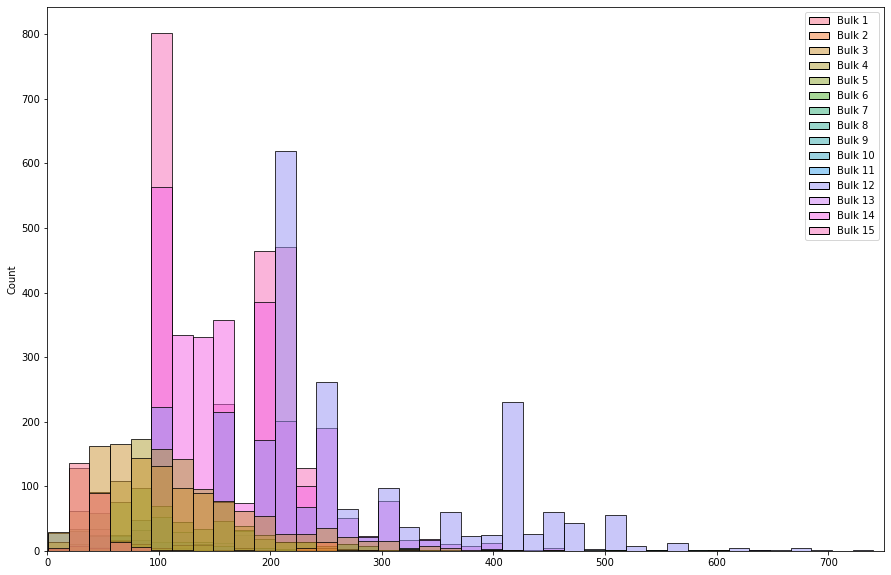

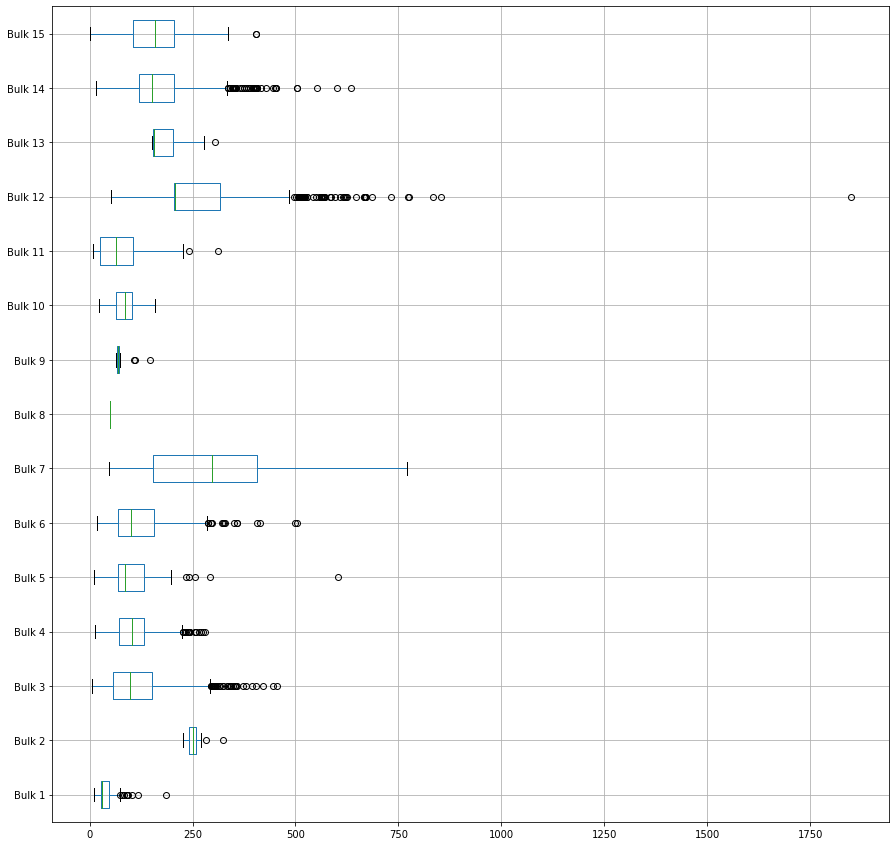

In [23]:
plt.figure(figsize=(15,10))
sns.histplot(bulk2,bins=100, alpha=0.5)
plt.xlim(0,750)
plt.figure(figsize=(15, 15))
bulk2.boxplot([col for col in bulk2.columns], vert=False)
plt.show()

Bulk 8 добавляли лишь один раз.
Bulk 12 есть аномально большое значение удалим его.

##### Данные о продувке сплава газом

In [24]:
data_gas

key      Газ 1
0        1  29.749986
1        2  12.555561
2        3  28.554793
3        4  18.841219
4        5   5.413692
...    ...        ...
3234  3237   5.543905
3235  3238   6.745669
3236  3239  16.023518
3237  3240  11.863103
3238  3241  12.680959

[3239 rows x 2 columns]

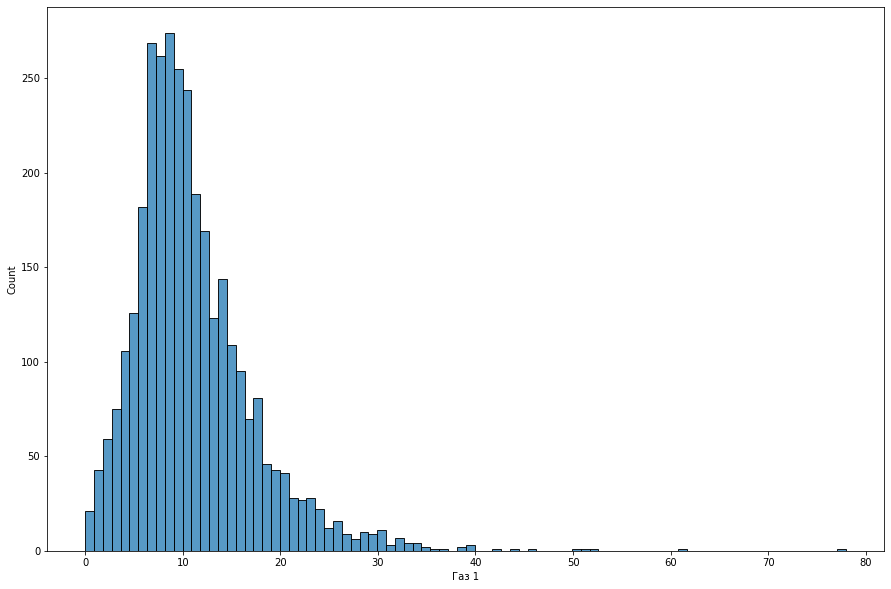

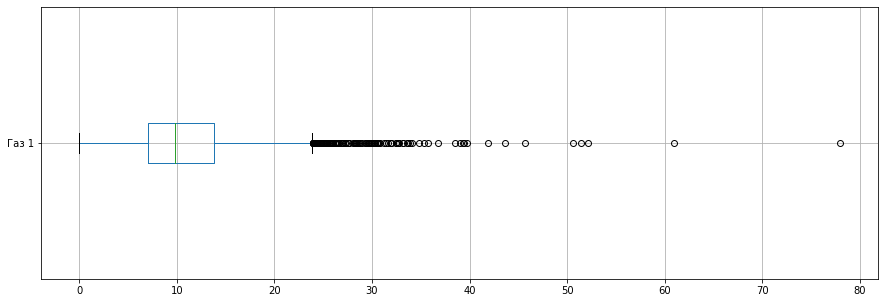

In [25]:
plt.figure(figsize=(15,10))
sns.histplot(data_gas['Газ 1'])
plt.figure(figsize=(15, 5))
data_gas.boxplot('Газ 1', vert=False)
plt.show()

In [26]:
data_gas['Газ 1'].shape

(3239,)

In [27]:
data_gas[data_gas['Газ 1'] > 25].count()

key      101
Газ 1    101
dtype: int64

In [28]:
data_gas[data_gas['Газ 1'] > 30].count()

key      46
Газ 1    46
dtype: int64

Думаю тут стоит уточнить значения у заказчика, я бы откинул значения больше 30

##### Данные о результах измерения температуры

In [29]:
data_temp

key         Время замера  Температура
0         1  2019-05-03 11:02:04       1571.0
1         1  2019-05-03 11:07:18       1604.0
2         1  2019-05-03 11:11:34       1618.0
3         1  2019-05-03 11:18:04       1601.0
4         1  2019-05-03 11:25:59       1606.0
...     ...                  ...          ...
18087  3241  2019-09-06 16:55:01          NaN
18088  3241  2019-09-06 17:06:38          NaN
18089  3241  2019-09-06 17:21:48          NaN
18090  3241  2019-09-06 17:24:44          NaN
18091  3241  2019-09-06 17:30:05          NaN

[18092 rows x 3 columns]

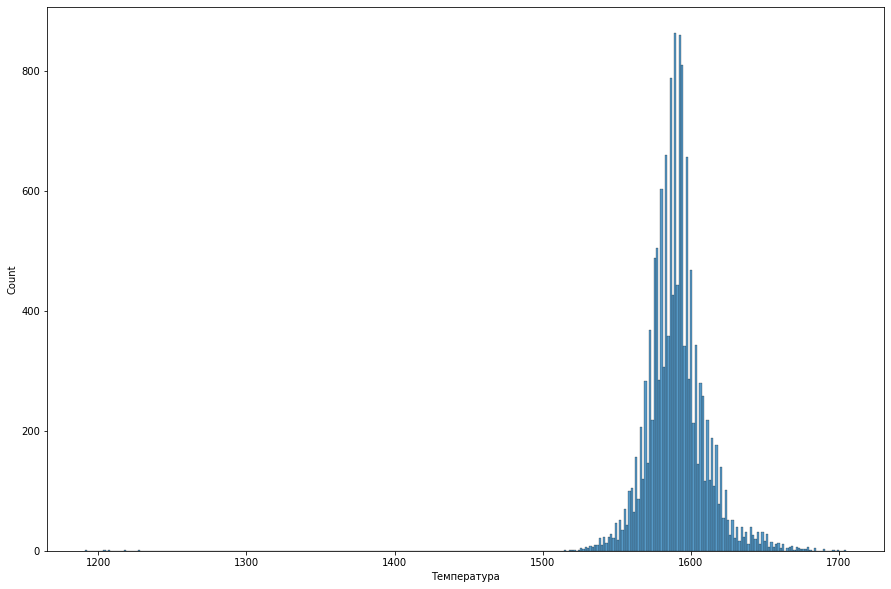

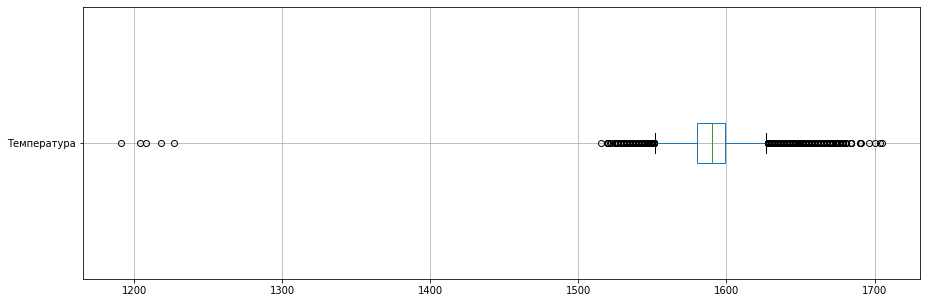

In [30]:
plt.figure(figsize=(15,10))
sns.histplot(data_temp['Температура'])
plt.figure(figsize=(15, 5))
data_temp.boxplot('Температура', vert=False)
plt.show()

In [31]:
data_temp['Температура'].mean()

1590.7227412205932

по условию необходимо будет убрать значения меньше 1500

In [32]:
data_temp[data_temp['Температура'] <= 1500]

key         Время замера  Температура
4883    867  2019-06-06 08:03:39       1191.0
6784   1214  2019-06-18 08:01:03       1208.0
9050   1619  2019-07-03 02:34:41       1218.0
11495  2052  2019-07-25 08:49:15       1227.0
14283  2561  2019-08-12 18:49:29       1204.0

##### Данные о проволочных материалах (объём)

In [33]:
data_wire

key      Wire 1   Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  \
0        1   60.059998      NaN     NaN     NaN     NaN     NaN     NaN   
1        2   96.052315      NaN     NaN     NaN     NaN     NaN     NaN   
2        3   91.160157      NaN     NaN     NaN     NaN     NaN     NaN   
3        4   89.063515      NaN     NaN     NaN     NaN     NaN     NaN   
4        5   89.238236  9.11456     NaN     NaN     NaN     NaN     NaN   
...    ...         ...      ...     ...     ...     ...     ...     ...   
3076  3237   38.088959      NaN     NaN     NaN     NaN     NaN     NaN   
3077  3238   56.128799      NaN     NaN     NaN     NaN     NaN     NaN   
3078  3239  143.357761      NaN     NaN     NaN     NaN     NaN     NaN   
3079  3240   34.070400      NaN     NaN     NaN     NaN     NaN     NaN   
3080  3241   63.117595      NaN     NaN     NaN     NaN     NaN     NaN   

      Wire 8  Wire 9  
0        NaN     NaN  
1        NaN     NaN  
2        NaN     NaN  
3        NaN     NaN  
4        NaN     NaN  
...      ...     ...  
3076     NaN     NaN  
3077     NaN     NaN  
3078     NaN     NaN  
3079     NaN     NaN  
3080     NaN     NaN  

[3081 rows x 10 columns]

In [34]:
data_wire.describe(include='all')

key       Wire 1       Wire 2      Wire 3      Wire 4  Wire 5  \
count  3081.000000  3055.000000  1079.000000   63.000000   14.000000   1.000   
mean   1623.426485   100.895853    50.577323  189.482681   57.442841  15.132   
std     932.996726    42.012518    39.320216   99.513444   28.824667     NaN   
min       1.000000     1.918800     0.030160    0.144144   24.148801  15.132   
25%     823.000000    72.115684    20.193680   95.135044   40.807002  15.132   
50%    1619.000000   100.158234    40.142956  235.194977   45.234282  15.132   
75%    2434.000000   126.060483    70.227558  276.252014   76.124619  15.132   
max    3241.000000   330.314424   282.780152  385.008668  113.231044  15.132   

           Wire 6     Wire 7      Wire 8     Wire 9  
count   73.000000  11.000000   19.000000  29.000000  
mean    48.016974  10.039007   53.625193  34.155752  
std     33.919845   8.610584   16.881728  19.931616  
min      0.034320   0.234208   45.076721   4.622800  
25%     25.053600   6.762756   46.094879  22.058401  
50%     42.076324   9.017009   46.279999  30.066399  
75%     64.212723  11.886057   48.089603  43.862003  
max    180.454575  32.847674  102.762401  90.053604

In [35]:
data_wire[data_wire['Wire 5'].notna()]

key    Wire 1  Wire 2     Wire 3  Wire 4  Wire 5     Wire 6  Wire 7  \
2440  2567  18.30192     NaN  96.288193     NaN  15.132  73.307526     NaN   

      Wire 8  Wire 9  
2440     NaN     NaN

In [36]:
wire2 = data_wire.copy()

In [37]:
wire2.drop(['key'], axis=1, inplace=True)

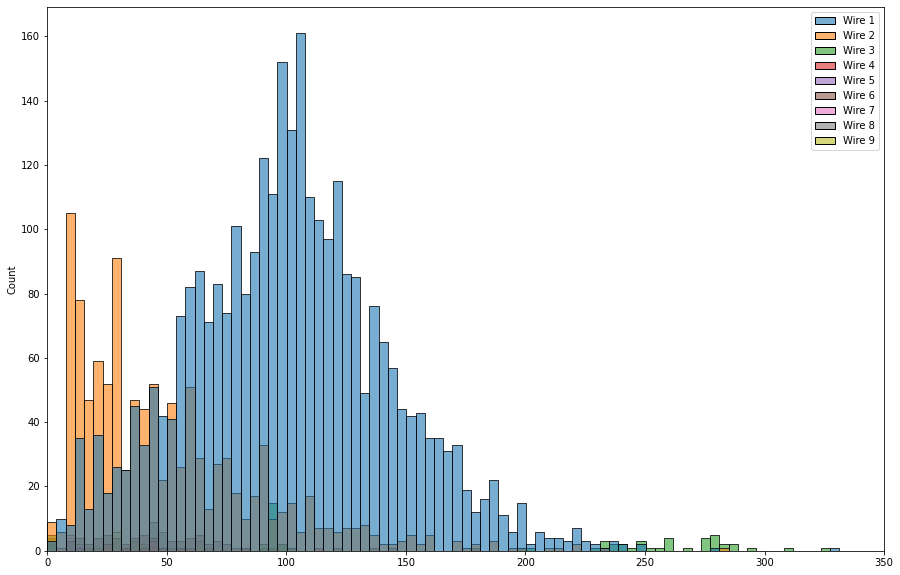

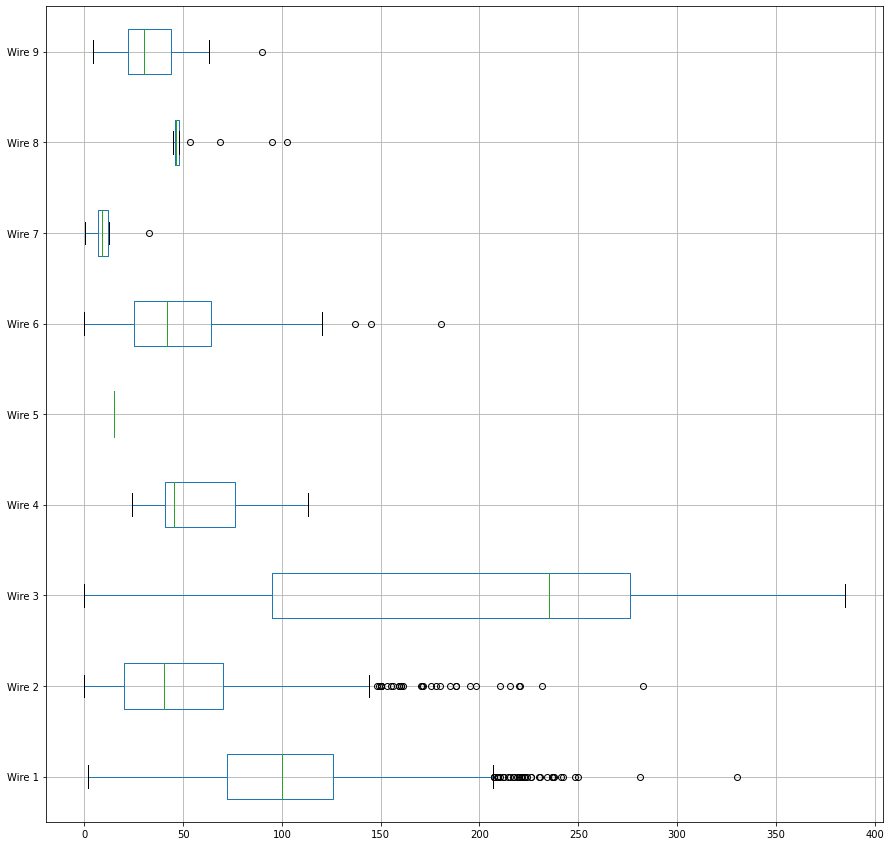

In [38]:
plt.figure(figsize=(15,10))
sns.histplot(wire2,bins=100, alpha=0.6)
plt.xlim(0,350)
plt.figure(figsize=(15, 15))
wire2.boxplot([col for col in wire2.columns], vert=False)
plt.show()

ware 1 и ware 2 - удалим выбросы
также удалим ware 5 - встречается только 1 раз.

#### Выводы:<br>
    1. Ознакомились с данными, провели анализ, построили графики
    2. Увидели, что в целевом признаке data_temp, пресутсвуют пропуски, а также выяснили, что для дальнейшей работы, нам не нужны промежуточные значения температуры ( только первый и последний замер)
    3. Увидели, что в  материалах есть пустые значения, которые можно заменить 0, так как это значит, что материал не добавлялся.
    4. Убедились, что во всех таблица отсутствуют дубликаты
    5. Узнали, что Реактивная мощность не может быть меньше 0, а значит значения меньше этого можно отбросить
    6. В данных о подаче сыпучих материалов. Материал Bulk 8 добавляли лишь один раз, а Bulk 12 есть аномально большое значение удалим его.
    7. Узнали, что значения температуры не могут быть меньше 1500 градусов
    8. В данных о проволочных материалах: материалы ware 1 и ware 2 имеют выбросы, также удалим материал ware 5 - встречается только 1 раз.

### Подготовка данных

В данном пункте мы избавимся от выбросов, удалим или заполним пустые значения

#### <strong> Данные об электродах

In [39]:
data_arc.head(5)

key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
0    1  2019-05-03 11:02:14  2019-05-03 11:06:02           0.305130   
1    1  2019-05-03 11:07:28  2019-05-03 11:10:33           0.765658   
2    1  2019-05-03 11:11:44  2019-05-03 11:14:36           0.580313   
3    1  2019-05-03 11:18:14  2019-05-03 11:24:19           0.518496   
4    1  2019-05-03 11:26:09  2019-05-03 11:28:37           0.867133   

   Реактивная мощность  
0             0.211253  
1             0.477438  
2             0.430460  
3             0.379979  
4             0.643691

В данной таблице нам нужно:<br>
● есть отрицательное значение в реактивной мощности – нужно удалить этот ключ целиком<br>
● есть ключи с одним замером – удалить их<br>
● агрегировать данные в тех таблицах, где для одной партии имеются несколько итераций (строк) <br>

При рассмотрении таблицы пропусков и дубликатов обнаружено не было.

In [40]:
print('Кол-во дубликатов:', data_arc.duplicated().sum())
print('--')
print('Кол-во пропусков:',data_arc.isnull().sum())

Кол-во дубликатов: 0
--
Кол-во пропусков: key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64


сделаем копию таблицы, чтобы в случае ошибки не потерять данные

In [41]:
data_arc_copy = data_arc.copy()

In [42]:
data_arc_copy.head()

key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
0    1  2019-05-03 11:02:14  2019-05-03 11:06:02           0.305130   
1    1  2019-05-03 11:07:28  2019-05-03 11:10:33           0.765658   
2    1  2019-05-03 11:11:44  2019-05-03 11:14:36           0.580313   
3    1  2019-05-03 11:18:14  2019-05-03 11:24:19           0.518496   
4    1  2019-05-03 11:26:09  2019-05-03 11:28:37           0.867133   

   Реактивная мощность  
0             0.211253  
1             0.477438  
2             0.430460  
3             0.379979  
4             0.643691

In [43]:
data_arc_copy.shape

(14876, 5)

удалим те значения отрицательное значение в реактивной мощности

In [44]:
data_arc_copy[data_arc_copy['Реактивная мощность'] <= 0]

key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
9780  2116  2019-07-28 02:22:08  2019-07-28 02:23:57           0.705344   

      Реактивная мощность  
9780          -715.479924

In [45]:
data_arc_copy = data_arc_copy[data_arc_copy['Реактивная мощность'] >= 0]

In [46]:
data_arc_copy.shape

(14875, 5)

In [47]:
data_arc_copy[data_arc_copy['Реактивная мощность'] <= 0]

Empty DataFrame
Columns: [key, Начало нагрева дугой, Конец нагрева дугой, Активная мощность, Реактивная мощность]
Index: []

значение удалено

Удалить ключи с одним замером

Получим список ключей

In [48]:
key_list_arc = data_arc_copy['key'].value_counts()

In [49]:
key_list_arc

2108    16
1689    15
1513    15
2567    14
46      13
        ..
247      1
2582     1
943      1
248      1
530      1
Name: key, Length: 3214, dtype: int64

In [50]:
key_list_arc = key_list_arc.to_frame(name='count').reset_index()

In [51]:
key_list_arc

index  count
0      2108     16
1      1689     15
2      1513     15
3      2567     14
4        46     13
...     ...    ...
3209    247      1
3210   2582      1
3211    943      1
3212    248      1
3213    530      1

[3214 rows x 2 columns]

получим список индексов

In [52]:
key_list_arc.query('count == 1').count()

index    39
count    39
dtype: int64

In [53]:
key_list_arc[key_list_arc['count'] <= 1]

index  count
3175   2112      1
3176   2025      1
3177    977      1
3178    246      1
3179   1911      1
3180   3112      1
3181   1988      1
3182    732      1
3183   1914      1
3184   1369      1
3185    343      1
3186   1766      1
3187   2841      1
3188   1974      1
3189   1169      1
3190   2738      1
3191   1449      1
3192   2179      1
3193    614      1
3194   3026      1
3195   3059      1
3196   1535      1
3197   1281      1
3198    556      1
3199   2472      1
3200   1615      1
3201   1568      1
3202    661      1
3203   2194      1
3204    269      1
3205   2795      1
3206   1268      1
3207     49      1
3208    112      1
3209    247      1
3210   2582      1
3211    943      1
3212    248      1
3213    530      1

In [54]:
key_list_arc = key_list_arc['index'][key_list_arc['count'] <= 1].to_list()

In [55]:
key_list_arc

[2112,
 2025,
 977,
 246,
 1911,
 3112,
 1988,
 732,
 1914,
 1369,
 343,
 1766,
 2841,
 1974,
 1169,
 2738,
 1449,
 2179,
 614,
 3026,
 3059,
 1535,
 1281,
 556,
 2472,
 1615,
 1568,
 661,
 2194,
 269,
 2795,
 1268,
 49,
 112,
 247,
 2582,
 943,
 248,
 530]

In [56]:
data_arc_copy = data_arc_copy.query('key not in @key_list_arc')

In [57]:
data_arc_copy.tail()

key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
14871  3241  2019-09-06 16:49:05  2019-09-06 16:51:42           0.439735   
14872  3241  2019-09-06 16:55:11  2019-09-06 16:58:11           0.646498   
14873  3241  2019-09-06 17:06:48  2019-09-06 17:09:52           1.039726   
14874  3241  2019-09-06 17:21:58  2019-09-06 17:22:55           0.530267   
14875  3241  2019-09-06 17:24:54  2019-09-06 17:26:15           0.389057   

       Реактивная мощность  
14871             0.299579  
14872             0.458240  
14873             0.769302  
14874             0.361543  
14875             0.251347

In [58]:
data_arc_copy.shape

(14836, 5)

Удалили ключи с одним измерением

добавим доп.колонку время нагрева

In [59]:
data_arc_copy.dtypes

key                       int64
Начало нагрева дугой     object
Конец нагрева дугой      object
Активная мощность       float64
Реактивная мощность     float64
dtype: object

In [60]:
data_arc_copy['Начало нагрева дугой'] = data_arc_copy['Начало нагрева дугой'].astype('datetime64[ns]')

In [61]:
data_arc_copy['Конец нагрева дугой'] = data_arc_copy['Конец нагрева дугой'].astype('datetime64[ns]')

In [62]:
data_arc_copy['Время нагрева, сек'] = (data_arc_copy['Конец нагрева дугой'] - data_arc_copy['Начало нагрева дугой']) / np.timedelta64 ( 1 , 's')

In [63]:
data_arc_copy['Время нагрева, сек'] = data_arc_copy['Время нагрева, сек'].astype('int')

In [64]:
data_arc_copy.tail()

key Начало нагрева дугой Конец нагрева дугой  Активная мощность  \
14871  3241  2019-09-06 16:49:05 2019-09-06 16:51:42           0.439735   
14872  3241  2019-09-06 16:55:11 2019-09-06 16:58:11           0.646498   
14873  3241  2019-09-06 17:06:48 2019-09-06 17:09:52           1.039726   
14874  3241  2019-09-06 17:21:58 2019-09-06 17:22:55           0.530267   
14875  3241  2019-09-06 17:24:54 2019-09-06 17:26:15           0.389057   

       Реактивная мощность  Время нагрева, сек  
14871             0.299579                 157  
14872             0.458240                 180  
14873             0.769302                 184  
14874             0.361543                  57  
14875             0.251347                  81

Проверим, если такие значения времени нагрева, где возможно перепутали даты или не правильноуказали их.

In [65]:
data_arc_copy['Время нагрева, сек'][data_arc_copy['Время нагрева, сек'] <= 0 ] 

Series([], Name: Время нагрева, сек, dtype: int64)

Таких значений нет.

Добавим новые колонки

Полная мощность рассчитывается по формуле:

$$S = \sqrt{P^2 + Q^2}$$

Где,
S – полная мощность
P – активная составляющая 
Q – реактивная составляющая 


In [66]:
data_arc_copy['Полная мощность'] = (data_arc_copy['Активная мощность'] ** 2 + data_arc_copy['Реактивная мощность'] ** 2) **(1/2)

In [67]:
data_arc_copy.tail()

key Начало нагрева дугой Конец нагрева дугой  Активная мощность  \
14871  3241  2019-09-06 16:49:05 2019-09-06 16:51:42           0.439735   
14872  3241  2019-09-06 16:55:11 2019-09-06 16:58:11           0.646498   
14873  3241  2019-09-06 17:06:48 2019-09-06 17:09:52           1.039726   
14874  3241  2019-09-06 17:21:58 2019-09-06 17:22:55           0.530267   
14875  3241  2019-09-06 17:24:54 2019-09-06 17:26:15           0.389057   

       Реактивная мощность  Время нагрева, сек  Полная мощность  
14871             0.299579                 157         0.532085  
14872             0.458240                 180         0.792429  
14873             0.769302                 184         1.293389  
14874             0.361543                  57         0.641792  
14875             0.251347                  81         0.463185

Работа рассчитывается по формуле:

$$P = A/t$$

Где,
P – мощность
A – работа
е – время,С 

Следовательно работа:

$$A = P * t$$

In [68]:
data_arc_copy['Работа'] = data_arc_copy['Полная мощность'] * data_arc_copy['Время нагрева, сек']

In [69]:
data_arc_pivot = pd.pivot_table(data_arc_copy,
                             values=['Активная мощность','Реактивная мощность','Время нагрева, сек','Полная мощность','Работа'],
                             index='key',
                             aggfunc = np.sum).reset_index()

In [70]:
data_arc_pivot

key  Активная мощность  Время нагрева, сек  Полная мощность    Работа  \
0        1           3.036730                1098         3.718736  3.053450   
1        2           2.139408                 811         2.588349  1.956857   
2        3           4.063641                 655         5.019223  5.756776   
3        4           2.706489                 741         3.400038  3.215134   
4        5           2.252950                 869         2.816980  2.247989   
...    ...                ...                 ...              ...       ...   
3170  3237           2.541872                 909         3.250657  2.870009   
3171  3238           1.374821                 546         1.723937  1.092783   
3172  3239           4.848005                1216         6.014480  4.830263   
3173  3240           3.317679                 839         4.082920  3.944916   
3174  3241           3.045283                 659         3.722880  3.210351   

      Реактивная мощность  
0                2.142821  
1                1.453357  
2                2.937457  
3                2.056992  
4                1.687991  
...                   ...  
3170             2.025417  
3171             1.038103  
3172             3.541541  
3173             2.373552  
3174             2.140011  

[3175 rows x 6 columns]

#### Данные о подаче сыпучих материалов (объём):

data_bulk.csv — данные о подаче сыпучих материалов (объём) <br>
data_bulk_time.csv — данные о подаче сыпучих материалов (время)<br>

In [71]:
data_bulk

key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
0        1     NaN     NaN     NaN    43.0     NaN     NaN     NaN     NaN   
1        2     NaN     NaN     NaN    73.0     NaN     NaN     NaN     NaN   
2        3     NaN     NaN     NaN    34.0     NaN     NaN     NaN     NaN   
3        4     NaN     NaN     NaN    81.0     NaN     NaN     NaN     NaN   
4        5     NaN     NaN     NaN    78.0     NaN     NaN     NaN     NaN   
...    ...     ...     ...     ...     ...     ...     ...     ...     ...   
3124  3237     NaN     NaN   170.0     NaN     NaN     NaN     NaN     NaN   
3125  3238     NaN     NaN   126.0     NaN     NaN     NaN     NaN     NaN   
3126  3239     NaN     NaN     NaN     NaN     NaN   114.0     NaN     NaN   
3127  3240     NaN     NaN     NaN     NaN     NaN    26.0     NaN     NaN   
3128  3241     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

      Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
0        NaN      NaN      NaN    206.0      NaN    150.0    154.0  
1        NaN      NaN      NaN    206.0      NaN    149.0    154.0  
2        NaN      NaN      NaN    205.0      NaN    152.0    153.0  
3        NaN      NaN      NaN    207.0      NaN    153.0    154.0  
4        NaN      NaN      NaN    203.0      NaN    151.0    152.0  
...      ...      ...      ...      ...      ...      ...      ...  
3124     NaN      NaN      NaN    252.0      NaN    130.0    206.0  
3125     NaN      NaN      NaN    254.0      NaN    108.0    106.0  
3126     NaN      NaN      NaN    158.0      NaN    270.0     88.0  
3127     NaN      NaN      NaN      NaN      NaN    192.0     54.0  
3128     NaN      NaN      NaN      NaN      NaN    180.0     52.0  

[3129 rows x 16 columns]

In [72]:
data_bulk_time

key Bulk 1 Bulk 2               Bulk 3               Bulk 4 Bulk 5  \
0        1    NaN    NaN                  NaN  2019-05-03 11:28:48    NaN   
1        2    NaN    NaN                  NaN  2019-05-03 11:36:50    NaN   
2        3    NaN    NaN                  NaN  2019-05-03 12:32:39    NaN   
3        4    NaN    NaN                  NaN  2019-05-03 12:43:22    NaN   
4        5    NaN    NaN                  NaN  2019-05-03 13:30:47    NaN   
...    ...    ...    ...                  ...                  ...    ...   
3124  3237    NaN    NaN  2019-09-06 11:54:15                  NaN    NaN   
3125  3238    NaN    NaN  2019-09-06 12:26:52                  NaN    NaN   
3126  3239    NaN    NaN                  NaN                  NaN    NaN   
3127  3240    NaN    NaN                  NaN                  NaN    NaN   
3128  3241    NaN    NaN                  NaN                  NaN    NaN   

                   Bulk 6 Bulk 7 Bulk 8 Bulk 9 Bulk 10 Bulk 11  \
0                     NaN    NaN    NaN    NaN     NaN     NaN   
1                     NaN    NaN    NaN    NaN     NaN     NaN   
2                     NaN    NaN    NaN    NaN     NaN     NaN   
3                     NaN    NaN    NaN    NaN     NaN     NaN   
4                     NaN    NaN    NaN    NaN     NaN     NaN   
...                   ...    ...    ...    ...     ...     ...   
3124                  NaN    NaN    NaN    NaN     NaN     NaN   
3125                  NaN    NaN    NaN    NaN     NaN     NaN   
3126  2019-09-06 15:06:00    NaN    NaN    NaN     NaN     NaN   
3127  2019-09-06 16:24:28    NaN    NaN    NaN     NaN     NaN   
3128                  NaN    NaN    NaN    NaN     NaN     NaN   

                  Bulk 12 Bulk 13              Bulk 14              Bulk 15  
0     2019-05-03 11:24:31     NaN  2019-05-03 11:14:50  2019-05-03 11:10:43  
1     2019-05-03 11:53:30     NaN  2019-05-03 11:48:37  2019-05-03 11:44:39  
2     2019-05-03 12:27:13     NaN  2019-05-03 12:21:01  2019-05-03 12:16:16  
3     2019-05-03 12:58:00     NaN  2019-05-03 12:51:11  2019-05-03 12:46:36  
4     2019-05-03 13:30:47     NaN  2019-05-03 13:34:12  2019-05-03 13:30:47  
...                   ...     ...                  ...                  ...  
3124  2019-09-06 11:49:45     NaN  2019-09-06 11:45:22  2019-09-06 11:40:06  
3125  2019-09-06 12:18:35     NaN  2019-09-06 12:31:49  2019-09-06 12:26:52  
3126  2019-09-06 15:01:44     NaN  2019-09-06 14:58:15  2019-09-06 14:48:06  
3127                  NaN     NaN  2019-09-06 16:07:29  2019-09-06 16:01:34  
3128                  NaN     NaN  2019-09-06 17:26:33  2019-09-06 17:23:15  

[3129 rows x 16 columns]

в таблице о материалах если нет, значиения значит матреиал не использовался и данные можно ззаполнить 0 

In [73]:
data_bulk_copy = data_bulk.copy()
data_bulk_time_copy = data_bulk_time.copy()

In [74]:
data_bulk_copy.isna().sum()

key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

In [75]:
data_bulk_copy = data_bulk_copy.fillna(0)

In [76]:
data_bulk_copy.isna().sum()

key        0
Bulk 1     0
Bulk 2     0
Bulk 3     0
Bulk 4     0
Bulk 5     0
Bulk 6     0
Bulk 7     0
Bulk 8     0
Bulk 9     0
Bulk 10    0
Bulk 11    0
Bulk 12    0
Bulk 13    0
Bulk 14    0
Bulk 15    0
dtype: int64

In [77]:
data_bulk_copy['key']

0          1
1          2
2          3
3          4
4          5
        ... 
3124    3237
3125    3238
3126    3239
3127    3240
3128    3241
Name: key, Length: 3129, dtype: int64

Пропуски заполнены

Также удалим выброс из Bulk 12

In [78]:
data_bulk_copy['Bulk 12'].mean()

203.9482262703739

In [79]:
data_bulk_copy['Bulk 12'].max()

1849.0

In [80]:
data_bulk_copy[data_bulk_copy['Bulk 12'] > 650]

key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
207    223     0.0     0.0   124.0     0.0     0.0     0.0     0.0     0.0   
303    322   185.0     0.0   101.0    58.0     0.0     0.0   406.0     0.0   
308    327    67.0     0.0     0.0   119.0     0.0     0.0     0.0     0.0   
418    444    52.0     0.0     0.0   115.0     0.0     0.0     0.0     0.0   
841    877    90.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
960   1005    31.0     0.0   147.0     0.0     0.0     0.0     0.0     0.0   
1175  1224    31.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1410  1464    31.0     0.0     0.0   105.0     0.0     0.0     0.0     0.0   
1591  1650    31.0     0.0    49.0     0.0     0.0     0.0     0.0     0.0   
1629  1689     0.0     0.0     0.0     0.0     0.0   247.0     0.0     0.0   
1755  1816    62.0     0.0     0.0    92.0     0.0     0.0     0.0     0.0   
1933  1999    54.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2225  2305     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

      Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
207      0.0      0.0      0.0    666.0      0.0    316.0    202.0  
303      0.0      0.0      0.0   1849.0      0.0    636.0      0.0  
308      0.0      0.0      0.0    775.0      0.0    403.0    205.0  
418      0.0      0.0      0.0    671.0      0.0    379.0    203.0  
841      0.0     85.0      0.0    669.0      0.0    102.0      0.0  
960      0.0      0.0      0.0    668.0      0.0    198.0    205.0  
1175     0.0      0.0      0.0    668.0      0.0    213.0      0.0  
1410     0.0      0.0      0.0    774.0      0.0    306.0    100.0  
1591     0.0      0.0      0.0    667.0      0.0    199.0    106.0  
1629     0.0      0.0      0.0    733.0    305.0    248.0    224.0  
1755     0.0      0.0      0.0    833.0      0.0    249.0      0.0  
1933     0.0      0.0      0.0    853.0      0.0    366.0    290.0  
2225     0.0      0.0     22.0    685.0      0.0    199.0    206.0

In [81]:
data_bulk_copy = data_bulk_copy[data_bulk_copy['Bulk 12'] < 650]

In [82]:
data_bulk_copy.shape

(3116, 16)

In [83]:
data_bulk_copy.head()

key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
0    1     0.0     0.0     0.0    43.0     0.0     0.0     0.0     0.0   
1    2     0.0     0.0     0.0    73.0     0.0     0.0     0.0     0.0   
2    3     0.0     0.0     0.0    34.0     0.0     0.0     0.0     0.0   
3    4     0.0     0.0     0.0    81.0     0.0     0.0     0.0     0.0   
4    5     0.0     0.0     0.0    78.0     0.0     0.0     0.0     0.0   

   Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
0     0.0      0.0      0.0    206.0      0.0    150.0    154.0  
1     0.0      0.0      0.0    206.0      0.0    149.0    154.0  
2     0.0      0.0      0.0    205.0      0.0    152.0    153.0  
3     0.0      0.0      0.0    207.0      0.0    153.0    154.0  
4     0.0      0.0      0.0    203.0      0.0    151.0    152.0

#### данные о проволочных материалах

In [84]:
data_wire

key      Wire 1   Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  \
0        1   60.059998      NaN     NaN     NaN     NaN     NaN     NaN   
1        2   96.052315      NaN     NaN     NaN     NaN     NaN     NaN   
2        3   91.160157      NaN     NaN     NaN     NaN     NaN     NaN   
3        4   89.063515      NaN     NaN     NaN     NaN     NaN     NaN   
4        5   89.238236  9.11456     NaN     NaN     NaN     NaN     NaN   
...    ...         ...      ...     ...     ...     ...     ...     ...   
3076  3237   38.088959      NaN     NaN     NaN     NaN     NaN     NaN   
3077  3238   56.128799      NaN     NaN     NaN     NaN     NaN     NaN   
3078  3239  143.357761      NaN     NaN     NaN     NaN     NaN     NaN   
3079  3240   34.070400      NaN     NaN     NaN     NaN     NaN     NaN   
3080  3241   63.117595      NaN     NaN     NaN     NaN     NaN     NaN   

      Wire 8  Wire 9  
0        NaN     NaN  
1        NaN     NaN  
2        NaN     NaN  
3        NaN     NaN  
4        NaN     NaN  
...      ...     ...  
3076     NaN     NaN  
3077     NaN     NaN  
3078     NaN     NaN  
3079     NaN     NaN  
3080     NaN     NaN  

[3081 rows x 10 columns]

In [85]:
data_wire_copy = data_wire.copy()

In [86]:
data_wire_copy.describe()

key       Wire 1       Wire 2      Wire 3      Wire 4  Wire 5  \
count  3081.000000  3055.000000  1079.000000   63.000000   14.000000   1.000   
mean   1623.426485   100.895853    50.577323  189.482681   57.442841  15.132   
std     932.996726    42.012518    39.320216   99.513444   28.824667     NaN   
min       1.000000     1.918800     0.030160    0.144144   24.148801  15.132   
25%     823.000000    72.115684    20.193680   95.135044   40.807002  15.132   
50%    1619.000000   100.158234    40.142956  235.194977   45.234282  15.132   
75%    2434.000000   126.060483    70.227558  276.252014   76.124619  15.132   
max    3241.000000   330.314424   282.780152  385.008668  113.231044  15.132   

           Wire 6     Wire 7      Wire 8     Wire 9  
count   73.000000  11.000000   19.000000  29.000000  
mean    48.016974  10.039007   53.625193  34.155752  
std     33.919845   8.610584   16.881728  19.931616  
min      0.034320   0.234208   45.076721   4.622800  
25%     25.053600   6.762756   46.094879  22.058401  
50%     42.076324   9.017009   46.279999  30.066399  
75%     64.212723  11.886057   48.089603  43.862003  
max    180.454575  32.847674  102.762401  90.053604

In [87]:
data_wire_copy.shape

(3081, 10)

заполним пропуски 0

In [88]:
data_wire_copy = data_wire_copy.fillna(0)

In [89]:
data_wire_copy

key      Wire 1   Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  \
0        1   60.059998  0.00000     0.0     0.0     0.0     0.0     0.0   
1        2   96.052315  0.00000     0.0     0.0     0.0     0.0     0.0   
2        3   91.160157  0.00000     0.0     0.0     0.0     0.0     0.0   
3        4   89.063515  0.00000     0.0     0.0     0.0     0.0     0.0   
4        5   89.238236  9.11456     0.0     0.0     0.0     0.0     0.0   
...    ...         ...      ...     ...     ...     ...     ...     ...   
3076  3237   38.088959  0.00000     0.0     0.0     0.0     0.0     0.0   
3077  3238   56.128799  0.00000     0.0     0.0     0.0     0.0     0.0   
3078  3239  143.357761  0.00000     0.0     0.0     0.0     0.0     0.0   
3079  3240   34.070400  0.00000     0.0     0.0     0.0     0.0     0.0   
3080  3241   63.117595  0.00000     0.0     0.0     0.0     0.0     0.0   

      Wire 8  Wire 9  
0        0.0     0.0  
1        0.0     0.0  
2        0.0     0.0  
3        0.0     0.0  
4        0.0     0.0  
...      ...     ...  
3076     0.0     0.0  
3077     0.0     0.0  
3078     0.0     0.0  
3079     0.0     0.0  
3080     0.0     0.0  

[3081 rows x 10 columns]

#### данные о продувке сплава газом

data_gas.csv

In [90]:
data_gas_copy = data_gas.copy()

In [91]:
data_gas_copy

key      Газ 1
0        1  29.749986
1        2  12.555561
2        3  28.554793
3        4  18.841219
4        5   5.413692
...    ...        ...
3234  3237   5.543905
3235  3238   6.745669
3236  3239  16.023518
3237  3240  11.863103
3238  3241  12.680959

[3239 rows x 2 columns]

In [92]:
data_gas_copy.rename(columns = {'Газ 1':'gas'}, inplace = True )

In [93]:
data_gas_copy

key        gas
0        1  29.749986
1        2  12.555561
2        3  28.554793
3        4  18.841219
4        5   5.413692
...    ...        ...
3234  3237   5.543905
3235  3238   6.745669
3236  3239  16.023518
3237  3240  11.863103
3238  3241  12.680959

[3239 rows x 2 columns]

#### Результаты измерения температуры

In [94]:
data_temp.head()

key         Время замера  Температура
0    1  2019-05-03 11:02:04       1571.0
1    1  2019-05-03 11:07:18       1604.0
2    1  2019-05-03 11:11:34       1618.0
3    1  2019-05-03 11:18:04       1601.0
4    1  2019-05-03 11:25:59       1606.0

● есть низкие температуры  < 1500 – нужно удалить из объединенной выборки

● есть ключи с одним замером – тоже удалить

● также удалить улючи где отсутствует первая и последняя  температура

In [95]:
data_temp_copy = data_temp.copy()
data_temp_copy.shape

(18092, 3)

In [96]:
data_temp_copy.tail()

key         Время замера  Температура
18087  3241  2019-09-06 16:55:01          NaN
18088  3241  2019-09-06 17:06:38          NaN
18089  3241  2019-09-06 17:21:48          NaN
18090  3241  2019-09-06 17:24:44          NaN
18091  3241  2019-09-06 17:30:05          NaN

In [97]:
data_temp_copy[data_temp_copy['key'] == 3241] 

key         Время замера  Температура
18086  3241  2019-09-06 16:48:55       1586.0
18087  3241  2019-09-06 16:55:01          NaN
18088  3241  2019-09-06 17:06:38          NaN
18089  3241  2019-09-06 17:21:48          NaN
18090  3241  2019-09-06 17:24:44          NaN
18091  3241  2019-09-06 17:30:05          NaN

In [98]:
data_temp_copy[data_temp_copy['key'] == 2108] 

key         Время замера  Температура
11825  2108  2019-07-27 10:41:03       1639.0
11826  2108  2019-07-27 11:07:14       1626.0
11827  2108  2019-07-27 11:13:27       1604.0
11828  2108  2019-07-27 11:15:35       1612.0
11829  2108  2019-07-27 11:19:16       1621.0
11830  2108  2019-07-27 11:23:02       1535.0
11831  2108  2019-07-27 13:39:22       1577.0
11832  2108  2019-07-27 13:45:09       1585.0
11833  2108  2019-07-27 13:49:26       1559.0
11834  2108  2019-07-27 14:01:13       1562.0
11835  2108  2019-07-27 15:10:40       1587.0
11836  2108  2019-07-27 15:17:49       1582.0
11837  2108  2019-07-27 15:21:39       1544.0
11838  2108  2019-07-27 15:32:25       1537.0
11839  2108  2019-07-27 16:22:44       1582.0
11840  2108  2019-07-27 16:32:07       1578.0
11841  2108  2019-07-27 16:36:34       1541.0

Удалим ключи с одним замером

In [99]:
keytc = data_temp_copy['key'].value_counts().to_frame(name='count').reset_index()

In [100]:
keytc

index  count
0      2108     17
1      1513     16
2      1689     16
3      2567     15
4       322     14
...     ...    ...
3211    556      2
3212   1169      2
3213    732      2
3214    195      1
3215    279      1

[3216 rows x 2 columns]

In [101]:
list_keytc = keytc['index'][keytc['count']==1].to_list()

In [102]:
data_temp_copy = data_temp_copy.query('key not in @list_keytc')

In [103]:
data_temp_copy.head()

key         Время замера  Температура
0    1  2019-05-03 11:02:04       1571.0
1    1  2019-05-03 11:07:18       1604.0
2    1  2019-05-03 11:11:34       1618.0
3    1  2019-05-03 11:18:04       1601.0
4    1  2019-05-03 11:25:59       1606.0

In [104]:
data_temp_copy.shape

(18090, 3)

In [105]:
temp_min = data_temp_copy.groupby('key').agg('min')['Время замера']

In [106]:
temp_min = pd.DataFrame(temp_min)

In [107]:
temp_min = temp_min.merge(data_temp_copy, on='Время замера', how='left')

In [108]:
temp_min

Время замера   key  Температура
0     2019-05-03 11:02:04     1       1571.0
1     2019-05-03 11:34:04     2       1581.0
2     2019-05-03 12:06:44     3       1596.0
3     2019-05-03 12:39:27     4       1601.0
4     2019-05-03 13:11:03     5       1576.0
...                   ...   ...          ...
3209  2019-09-06 11:31:15  3237       1569.0
3210  2019-09-06 12:16:15  3238       1584.0
3211  2019-09-06 14:16:50  3239       1598.0
3212  2019-09-06 15:25:21  3240       1617.0
3213  2019-09-06 16:48:55  3241       1586.0

[3214 rows x 3 columns]

In [109]:
temp_max = data_temp_copy.groupby('key').agg('max')['Время замера']
temp_max = pd.DataFrame(temp_max)

In [110]:
temp_max = temp_max.merge(data_temp_copy, on='Время замера', how='left')

In [111]:
temp_max


Время замера   key  Температура
0     2019-05-03 11:30:38     1       1613.0
1     2019-05-03 11:55:09     2       1602.0
2     2019-05-03 12:35:57     3       1599.0
3     2019-05-03 12:59:47     4       1625.0
4     2019-05-03 13:36:39     5       1602.0
...                   ...   ...          ...
3209  2019-09-06 11:55:45  3237          NaN
3210  2019-09-06 12:34:37  3238          NaN
3211  2019-09-06 15:09:55  3239          NaN
3212  2019-09-06 16:35:26  3240          NaN
3213  2019-09-06 17:30:05  3241          NaN

[3214 rows x 3 columns]

In [112]:
pivot_temp = temp_min.merge(temp_max, on='key', how='left')

In [113]:
pivot_temp

Время замера_x   key  Температура_x       Время замера_y  \
0     2019-05-03 11:02:04     1         1571.0  2019-05-03 11:30:38   
1     2019-05-03 11:34:04     2         1581.0  2019-05-03 11:55:09   
2     2019-05-03 12:06:44     3         1596.0  2019-05-03 12:35:57   
3     2019-05-03 12:39:27     4         1601.0  2019-05-03 12:59:47   
4     2019-05-03 13:11:03     5         1576.0  2019-05-03 13:36:39   
...                   ...   ...            ...                  ...   
3209  2019-09-06 11:31:15  3237         1569.0  2019-09-06 11:55:45   
3210  2019-09-06 12:16:15  3238         1584.0  2019-09-06 12:34:37   
3211  2019-09-06 14:16:50  3239         1598.0  2019-09-06 15:09:55   
3212  2019-09-06 15:25:21  3240         1617.0  2019-09-06 16:35:26   
3213  2019-09-06 16:48:55  3241         1586.0  2019-09-06 17:30:05   

      Температура_y  
0            1613.0  
1            1602.0  
2            1599.0  
3            1625.0  
4            1602.0  
...             ...  
3209            NaN  
3210            NaN  
3211            NaN  
3212            NaN  
3213            NaN  

[3214 rows x 5 columns]

In [114]:
pivot_temp = pivot_temp[['key','Время замера_x','Температура_x','Время замера_y','Температура_y']]

In [115]:
pivot_temp

key       Время замера_x  Температура_x       Время замера_y  \
0        1  2019-05-03 11:02:04         1571.0  2019-05-03 11:30:38   
1        2  2019-05-03 11:34:04         1581.0  2019-05-03 11:55:09   
2        3  2019-05-03 12:06:44         1596.0  2019-05-03 12:35:57   
3        4  2019-05-03 12:39:27         1601.0  2019-05-03 12:59:47   
4        5  2019-05-03 13:11:03         1576.0  2019-05-03 13:36:39   
...    ...                  ...            ...                  ...   
3209  3237  2019-09-06 11:31:15         1569.0  2019-09-06 11:55:45   
3210  3238  2019-09-06 12:16:15         1584.0  2019-09-06 12:34:37   
3211  3239  2019-09-06 14:16:50         1598.0  2019-09-06 15:09:55   
3212  3240  2019-09-06 15:25:21         1617.0  2019-09-06 16:35:26   
3213  3241  2019-09-06 16:48:55         1586.0  2019-09-06 17:30:05   

      Температура_y  
0            1613.0  
1            1602.0  
2            1599.0  
3            1625.0  
4            1602.0  
...             ...  
3209            NaN  
3210            NaN  
3211            NaN  
3212            NaN  
3213            NaN  

[3214 rows x 5 columns]

удалим температуру с ключами меньше 1500

In [116]:
keypt = pivot_temp.query('Температура_x <1500 or Температура_y < 1500')

In [117]:
keypt = keypt['key'].to_list()


In [118]:
keypt

[867, 1214, 1619, 2052, 2561]

In [119]:
pivot_temp = pivot_temp.query('key not in @keypt')

In [120]:
pivot_temp

key       Время замера_x  Температура_x       Время замера_y  \
0        1  2019-05-03 11:02:04         1571.0  2019-05-03 11:30:38   
1        2  2019-05-03 11:34:04         1581.0  2019-05-03 11:55:09   
2        3  2019-05-03 12:06:44         1596.0  2019-05-03 12:35:57   
3        4  2019-05-03 12:39:27         1601.0  2019-05-03 12:59:47   
4        5  2019-05-03 13:11:03         1576.0  2019-05-03 13:36:39   
...    ...                  ...            ...                  ...   
3209  3237  2019-09-06 11:31:15         1569.0  2019-09-06 11:55:45   
3210  3238  2019-09-06 12:16:15         1584.0  2019-09-06 12:34:37   
3211  3239  2019-09-06 14:16:50         1598.0  2019-09-06 15:09:55   
3212  3240  2019-09-06 15:25:21         1617.0  2019-09-06 16:35:26   
3213  3241  2019-09-06 16:48:55         1586.0  2019-09-06 17:30:05   

      Температура_y  
0            1613.0  
1            1602.0  
2            1599.0  
3            1625.0  
4            1602.0  
...             ...  
3209            NaN  
3210            NaN  
3211            NaN  
3212            NaN  
3213            NaN  

[3209 rows x 5 columns]

In [121]:
pivot_temp['Время замера_x'] = pivot_temp['Время замера_x'].astype('datetime64[ns]')
pivot_temp['Время замера_y'] = pivot_temp['Время замера_y'].astype('datetime64[ns]')

In [122]:
pivot_temp.dtypes

key                        int64
Время замера_x    datetime64[ns]
Температура_x            float64
Время замера_y    datetime64[ns]
Температура_y            float64
dtype: object

In [123]:
pivot_temp['Разница времени температур'] = (pivot_temp['Время замера_y'] - pivot_temp['Время замера_x']) / np.timedelta64 ( 1 , 's')

In [124]:
pivot_temp['Разница времени температур'] = pivot_temp['Разница времени температур'].astype('int')

In [125]:
pivot_temp

key      Время замера_x  Температура_x      Время замера_y  \
0        1 2019-05-03 11:02:04         1571.0 2019-05-03 11:30:38   
1        2 2019-05-03 11:34:04         1581.0 2019-05-03 11:55:09   
2        3 2019-05-03 12:06:44         1596.0 2019-05-03 12:35:57   
3        4 2019-05-03 12:39:27         1601.0 2019-05-03 12:59:47   
4        5 2019-05-03 13:11:03         1576.0 2019-05-03 13:36:39   
...    ...                 ...            ...                 ...   
3209  3237 2019-09-06 11:31:15         1569.0 2019-09-06 11:55:45   
3210  3238 2019-09-06 12:16:15         1584.0 2019-09-06 12:34:37   
3211  3239 2019-09-06 14:16:50         1598.0 2019-09-06 15:09:55   
3212  3240 2019-09-06 15:25:21         1617.0 2019-09-06 16:35:26   
3213  3241 2019-09-06 16:48:55         1586.0 2019-09-06 17:30:05   

      Температура_y  Разница времени температур  
0            1613.0                        1714  
1            1602.0                        1265  
2            1599.0                        1753  
3            1625.0                        1220  
4            1602.0                        1536  
...             ...                         ...  
3209            NaN                        1470  
3210            NaN                        1102  
3211            NaN                        3185  
3212            NaN                        4205  
3213            NaN                        2470  

[3209 rows x 6 columns]

Посмотрим пропуски в столбцах

In [126]:
pivot_temp = pivot_temp.dropna()

In [127]:
pivot_temp.shape

(2471, 6)

In [128]:
pivot_temp.tail()

key      Время замера_x  Температура_x      Время замера_y  \
2470  2495 2019-08-10 11:27:47         1570.0 2019-08-10 11:50:47   
2471  2496 2019-08-10 11:56:48         1554.0 2019-08-10 12:25:13   
2472  2497 2019-08-10 12:37:26         1571.0 2019-08-10 12:53:28   
2473  2498 2019-08-10 12:58:11         1591.0 2019-08-10 13:23:31   
2474  2499 2019-08-10 13:33:21         1569.0 2019-08-10 13:58:58   

      Температура_y  Разница времени температур  
2470         1591.0                        1380  
2471         1591.0                        1705  
2472         1589.0                         962  
2473         1594.0                        1520  
2474         1603.0                        1537

In [129]:
pivot_temp.shape

(2471, 6)

In [130]:
pivot_temp.drop(['Время замера_x', 'Время замера_y'], axis= 1 , inplace = True )

In [131]:
pivot_temp

key  Температура_x  Температура_y  Разница времени температур
0        1         1571.0         1613.0                        1714
1        2         1581.0         1602.0                        1265
2        3         1596.0         1599.0                        1753
3        4         1601.0         1625.0                        1220
4        5         1576.0         1602.0                        1536
...    ...            ...            ...                         ...
2470  2495         1570.0         1591.0                        1380
2471  2496         1554.0         1591.0                        1705
2472  2497         1571.0         1589.0                         962
2473  2498         1591.0         1594.0                        1520
2474  2499         1569.0         1603.0                        1537

[2471 rows x 4 columns]

In [132]:
pivot_temp.rename(columns = {'Температура_x':'temp_first','Температура_y':'temp_last' ,'Разница времени температур':'diff_temp_s'}, inplace = True )

In [133]:
pivot_temp['temp_first'] = pivot_temp['temp_first'].astype('int')
pivot_temp['temp_last'] = pivot_temp['temp_last'].astype('int')

In [134]:
pivot_temp

key  temp_first  temp_last  diff_temp_s
0        1        1571       1613         1714
1        2        1581       1602         1265
2        3        1596       1599         1753
3        4        1601       1625         1220
4        5        1576       1602         1536
...    ...         ...        ...          ...
2470  2495        1570       1591         1380
2471  2496        1554       1591         1705
2472  2497        1571       1589          962
2473  2498        1591       1594         1520
2474  2499        1569       1603         1537

[2471 rows x 4 columns]

#### Объединение таблиц

Объединим таблицы: pivot_temp,data_gas,data_wire_copy,data_bulk_copy,data_arc_pivot

In [135]:
data_svot = pd.merge(pivot_temp,data_gas_copy, how='inner', on='key')
data_svot

key  temp_first  temp_last  diff_temp_s        gas
0        1        1571       1613         1714  29.749986
1        2        1581       1602         1265  12.555561
2        3        1596       1599         1753  28.554793
3        4        1601       1625         1220  18.841219
4        5        1576       1602         1536   5.413692
...    ...         ...        ...          ...        ...
2464  2495        1570       1591         1380   7.125735
2465  2496        1554       1591         1705   9.412616
2466  2497        1571       1589          962   6.271699
2467  2498        1591       1594         1520  14.953657
2468  2499        1569       1603         1537  11.336151

[2469 rows x 5 columns]

In [136]:
data_wire_copy

key      Wire 1   Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  \
0        1   60.059998  0.00000     0.0     0.0     0.0     0.0     0.0   
1        2   96.052315  0.00000     0.0     0.0     0.0     0.0     0.0   
2        3   91.160157  0.00000     0.0     0.0     0.0     0.0     0.0   
3        4   89.063515  0.00000     0.0     0.0     0.0     0.0     0.0   
4        5   89.238236  9.11456     0.0     0.0     0.0     0.0     0.0   
...    ...         ...      ...     ...     ...     ...     ...     ...   
3076  3237   38.088959  0.00000     0.0     0.0     0.0     0.0     0.0   
3077  3238   56.128799  0.00000     0.0     0.0     0.0     0.0     0.0   
3078  3239  143.357761  0.00000     0.0     0.0     0.0     0.0     0.0   
3079  3240   34.070400  0.00000     0.0     0.0     0.0     0.0     0.0   
3080  3241   63.117595  0.00000     0.0     0.0     0.0     0.0     0.0   

      Wire 8  Wire 9  
0        0.0     0.0  
1        0.0     0.0  
2        0.0     0.0  
3        0.0     0.0  
4        0.0     0.0  
...      ...     ...  
3076     0.0     0.0  
3077     0.0     0.0  
3078     0.0     0.0  
3079     0.0     0.0  
3080     0.0     0.0  

[3081 rows x 10 columns]

In [137]:
data_svot = data_svot.merge(data_wire_copy, how='inner', on='key')
data_svot

key  temp_first  temp_last  diff_temp_s        gas      Wire 1  \
0        1        1571       1613         1714  29.749986   60.059998   
1        2        1581       1602         1265  12.555561   96.052315   
2        3        1596       1599         1753  28.554793   91.160157   
3        4        1601       1625         1220  18.841219   89.063515   
4        5        1576       1602         1536   5.413692   89.238236   
...    ...         ...        ...          ...        ...         ...   
2361  2495        1570       1591         1380   7.125735   89.150879   
2362  2496        1554       1591         1705   9.412616  114.179527   
2363  2497        1571       1589          962   6.271699   94.086723   
2364  2498        1591       1594         1520  14.953657  118.110717   
2365  2499        1569       1603         1537  11.336151  110.160958   

        Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  Wire 9  
0      0.00000     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
1      0.00000     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
2      0.00000     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
3      0.00000     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
4      9.11456     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
...        ...     ...     ...     ...     ...     ...     ...     ...  
2361   0.00000     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
2362   0.00000     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
2363   9.04800     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
2364   0.00000     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
2365  50.00528     0.0     0.0     0.0     0.0     0.0     0.0     0.0  

[2366 rows x 14 columns]

In [138]:
data_svot = data_svot.merge(data_bulk_copy, how='inner', on='key')
data_svot

key  temp_first  temp_last  diff_temp_s        gas      Wire 1  \
0        1        1571       1613         1714  29.749986   60.059998   
1        2        1581       1602         1265  12.555561   96.052315   
2        3        1596       1599         1753  28.554793   91.160157   
3        4        1601       1625         1220  18.841219   89.063515   
4        5        1576       1602         1536   5.413692   89.238236   
...    ...         ...        ...          ...        ...         ...   
2307  2495        1570       1591         1380   7.125735   89.150879   
2308  2496        1554       1591         1705   9.412616  114.179527   
2309  2497        1571       1589          962   6.271699   94.086723   
2310  2498        1591       1594         1520  14.953657  118.110717   
2311  2499        1569       1603         1537  11.336151  110.160958   

        Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  Wire 9  \
0      0.00000     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1      0.00000     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2      0.00000     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3      0.00000     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4      9.11456     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
...        ...     ...     ...     ...     ...     ...     ...     ...   
2307   0.00000     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2308   0.00000     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2309   9.04800     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2310   0.00000     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2311  50.00528     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

      Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  Bulk 9  \
0        0.0     0.0     0.0    43.0     0.0     0.0     0.0     0.0     0.0   
1        0.0     0.0     0.0    73.0     0.0     0.0     0.0     0.0     0.0   
2        0.0     0.0     0.0    34.0     0.0     0.0     0.0     0.0     0.0   
3        0.0     0.0     0.0    81.0     0.0     0.0     0.0     0.0     0.0   
4        0.0     0.0     0.0    78.0     0.0     0.0     0.0     0.0     0.0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
2307     0.0     0.0    21.0     0.0     0.0     0.0     0.0     0.0     0.0   
2308     0.0     0.0     0.0    63.0     0.0     0.0     0.0     0.0     0.0   
2309     0.0     0.0     0.0    85.0     0.0     0.0     0.0     0.0     0.0   
2310     0.0     0.0    90.0     0.0     0.0     0.0     0.0     0.0     0.0   
2311     0.0     0.0    47.0     0.0     0.0     0.0     0.0     0.0     0.0   

      Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
0         0.0      0.0    206.0      0.0    150.0    154.0  
1         0.0      0.0    206.0      0.0    149.0    154.0  
2         0.0      0.0    205.0      0.0    152.0    153.0  
3         0.0      0.0    207.0      0.0    153.0    154.0  
4         0.0      0.0    203.0      0.0    151.0    152.0  
...       ...      ...      ...      ...      ...      ...  
2307     90.0      0.0    256.0      0.0    129.0    223.0  
2308    122.0      0.0    256.0      0.0    129.0    226.0  
2309      0.0      0.0    230.0      0.0    124.0    226.0  
2310    101.0      0.0    206.0      0.0    129.0    207.0  
2311      0.0      0.0    233.0      0.0    126.0    227.0  

[2312 rows x 29 columns]

In [139]:
data_svot = data_svot.merge(data_arc_pivot, how='inner', on='key')
data_svot

key  temp_first  temp_last  diff_temp_s        gas      Wire 1  \
0        1        1571       1613         1714  29.749986   60.059998   
1        2        1581       1602         1265  12.555561   96.052315   
2        3        1596       1599         1753  28.554793   91.160157   
3        4        1601       1625         1220  18.841219   89.063515   
4        5        1576       1602         1536   5.413692   89.238236   
...    ...         ...        ...          ...        ...         ...   
2282  2495        1570       1591         1380   7.125735   89.150879   
2283  2496        1554       1591         1705   9.412616  114.179527   
2284  2497        1571       1589          962   6.271699   94.086723   
2285  2498        1591       1594         1520  14.953657  118.110717   
2286  2499        1569       1603         1537  11.336151  110.160958   

        Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  Wire 9  \
0      0.00000     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1      0.00000     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2      0.00000     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3      0.00000     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4      9.11456     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
...        ...     ...     ...     ...     ...     ...     ...     ...   
2282   0.00000     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2283   0.00000     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2284   9.04800     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2285   0.00000     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2286  50.00528     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

      Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  Bulk 9  \
0        0.0     0.0     0.0    43.0     0.0     0.0     0.0     0.0     0.0   
1        0.0     0.0     0.0    73.0     0.0     0.0     0.0     0.0     0.0   
2        0.0     0.0     0.0    34.0     0.0     0.0     0.0     0.0     0.0   
3        0.0     0.0     0.0    81.0     0.0     0.0     0.0     0.0     0.0   
4        0.0     0.0     0.0    78.0     0.0     0.0     0.0     0.0     0.0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
2282     0.0     0.0    21.0     0.0     0.0     0.0     0.0     0.0     0.0   
2283     0.0     0.0     0.0    63.0     0.0     0.0     0.0     0.0     0.0   
2284     0.0     0.0     0.0    85.0     0.0     0.0     0.0     0.0     0.0   
2285     0.0     0.0    90.0     0.0     0.0     0.0     0.0     0.0     0.0   
2286     0.0     0.0    47.0     0.0     0.0     0.0     0.0     0.0     0.0   

      Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  Активная мощность  \
0         0.0      0.0    206.0      0.0    150.0    154.0           3.036730   
1         0.0      0.0    206.0      0.0    149.0    154.0           2.139408   
2         0.0      0.0    205.0      0.0    152.0    153.0           4.063641   
3         0.0      0.0    207.0      0.0    153.0    154.0           2.706489   
4         0.0      0.0    203.0      0.0    151.0    152.0           2.252950   
...       ...      ...      ...      ...      ...      ...                ...   
2282     90.0      0.0    256.0      0.0    129.0    223.0           3.168133   
2283    122.0      0.0    256.0      0.0    129.0    226.0           4.174918   
2284      0.0      0.0    230.0      0.0    124.0    226.0           3.605239   
2285    101.0      0.0    206.0      0.0    129.0    207.0           3.202310   
2286      0.0      0.0    233.0      0.0    126.0    227.0           1.737084   

      Время нагрева, сек  Полная мощность    Работа  Реактивная мощность  
0                   1098         3.718736  3.053450             2.142821  
1                    811         2.588349  1.956857             1.453357  
2                    655         5.019223  5.756776             2.937457  
3      

приведем столбцов к нормальному виду

In [140]:
data_svot.rename(columns = {'Активная мощность':'active_power','Время нагрева, сек':'heating_time_s'
   ,'Полная мощность':'full_power','Работа':'mech_work','Реактивная мощность':'reactive_power'}, inplace = True )

In [141]:
data_svot

key  temp_first  temp_last  diff_temp_s        gas      Wire 1  \
0        1        1571       1613         1714  29.749986   60.059998   
1        2        1581       1602         1265  12.555561   96.052315   
2        3        1596       1599         1753  28.554793   91.160157   
3        4        1601       1625         1220  18.841219   89.063515   
4        5        1576       1602         1536   5.413692   89.238236   
...    ...         ...        ...          ...        ...         ...   
2282  2495        1570       1591         1380   7.125735   89.150879   
2283  2496        1554       1591         1705   9.412616  114.179527   
2284  2497        1571       1589          962   6.271699   94.086723   
2285  2498        1591       1594         1520  14.953657  118.110717   
2286  2499        1569       1603         1537  11.336151  110.160958   

        Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  Wire 9  \
0      0.00000     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1      0.00000     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2      0.00000     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3      0.00000     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4      9.11456     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
...        ...     ...     ...     ...     ...     ...     ...     ...   
2282   0.00000     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2283   0.00000     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2284   9.04800     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2285   0.00000     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2286  50.00528     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

      Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  Bulk 9  \
0        0.0     0.0     0.0    43.0     0.0     0.0     0.0     0.0     0.0   
1        0.0     0.0     0.0    73.0     0.0     0.0     0.0     0.0     0.0   
2        0.0     0.0     0.0    34.0     0.0     0.0     0.0     0.0     0.0   
3        0.0     0.0     0.0    81.0     0.0     0.0     0.0     0.0     0.0   
4        0.0     0.0     0.0    78.0     0.0     0.0     0.0     0.0     0.0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
2282     0.0     0.0    21.0     0.0     0.0     0.0     0.0     0.0     0.0   
2283     0.0     0.0     0.0    63.0     0.0     0.0     0.0     0.0     0.0   
2284     0.0     0.0     0.0    85.0     0.0     0.0     0.0     0.0     0.0   
2285     0.0     0.0    90.0     0.0     0.0     0.0     0.0     0.0     0.0   
2286     0.0     0.0    47.0     0.0     0.0     0.0     0.0     0.0     0.0   

      Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  active_power  \
0         0.0      0.0    206.0      0.0    150.0    154.0      3.036730   
1         0.0      0.0    206.0      0.0    149.0    154.0      2.139408   
2         0.0      0.0    205.0      0.0    152.0    153.0      4.063641   
3         0.0      0.0    207.0      0.0    153.0    154.0      2.706489   
4         0.0      0.0    203.0      0.0    151.0    152.0      2.252950   
...       ...      ...      ...      ...      ...      ...           ...   
2282     90.0      0.0    256.0      0.0    129.0    223.0      3.168133   
2283    122.0      0.0    256.0      0.0    129.0    226.0      4.174918   
2284      0.0      0.0    230.0      0.0    124.0    226.0      3.605239   
2285    101.0      0.0    206.0      0.0    129.0    207.0      3.202310   
2286      0.0      0.0    233.0      0.0    126.0    227.0      1.737084   

      heating_time_s  full_power  mech_work  reactive_power  
0               1098    3.718736   3.053450        2.142821  
1                811    2.588349   1.956857        1.453357  
2                655    5.019223   5.756776        2.937457  
3                741    3.400038   3.215134        2.056992  
4                869    2.816980   2.247989        1.6879

In [142]:
data_svot.columns = [re.sub('(?<!^)(?=[A-Z])', '_', i).lower() for i in data_svot.columns]

In [143]:
data_svot.columns = [re.sub("\s",'_', i) for i in data_svot.columns]

In [144]:
data_svot.columns

Index(['key', 'temp_first', 'temp_last', 'diff_temp_s', 'gas', 'wire_1',
       'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8',
       'wire_9', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15', 'active_power', 'heating_time_s',
       'full_power', 'mech_work', 'reactive_power'],
      dtype='object')

Удалим ключ "key" и поменяем местами колонки

In [145]:
data_svot = data_svot[['temp_first','temp_last','diff_temp_s','active_power','heating_time_s','full_power',
                       'mech_work','reactive_power','gas','wire_1',
       'wire_2', 'wire_3', 'wire_4', 'wire_6', 'wire_7', 'wire_8',
       'wire_9', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15',]]

In [146]:
data_svot.tail()

temp_first  temp_last  diff_temp_s  active_power  heating_time_s  \
2282        1570       1591         1380      3.168133             723   
2283        1554       1591         1705      4.174918             940   
2284        1571       1589          962      3.605239             569   
2285        1591       1594         1520      3.202310             750   
2286        1569       1603         1537      1.737084             883   

      full_power  mech_work  reactive_power        gas      wire_1    wire_2  \
2282    3.868721   4.003920        2.210936   7.125735   89.150879   0.00000   
2283    5.070316   5.684912        2.872031   9.412616  114.179527   0.00000   
2284    4.360918   6.391294        2.452092   6.271699   94.086723   9.04800   
2285    3.909917   3.463519        2.239820  14.953657  118.110717   0.00000   
2286    2.169252   1.335749        1.296836  11.336151  110.160958  50.00528   

      wire_3  wire_4  wire_6  wire_7  wire_8  wire_9  bulk_1  bulk_2  bulk_3  \
2282     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0    21.0   
2283     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2284     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2285     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0    90.0   
2286     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0    47.0   

      bulk_4  bulk_5  bulk_6  bulk_7  bulk_8  bulk_9  bulk_10  bulk_11  \
2282     0.0     0.0     0.0     0.0     0.0     0.0     90.0      0.0   
2283    63.0     0.0     0.0     0.0     0.0     0.0    122.0      0.0   
2284    85.0     0.0     0.0     0.0     0.0     0.0      0.0      0.0   
2285     0.0     0.0     0.0     0.0     0.0     0.0    101.0      0.0   
2286     0.0     0.0     0.0     0.0     0.0     0.0      0.0      0.0   

      bulk_12  bulk_13  bulk_14  bulk_15  
2282    256.0      0.0    129.0    223.0  
2283    256.0      0.0    129.0    226.0  
2284    230.0      0.0    124.0    226.0  
2285    206.0      0.0    129.0    207.0  
2286    233.0      0.0    126.0    227.0

#### Матрица кореляции признаков

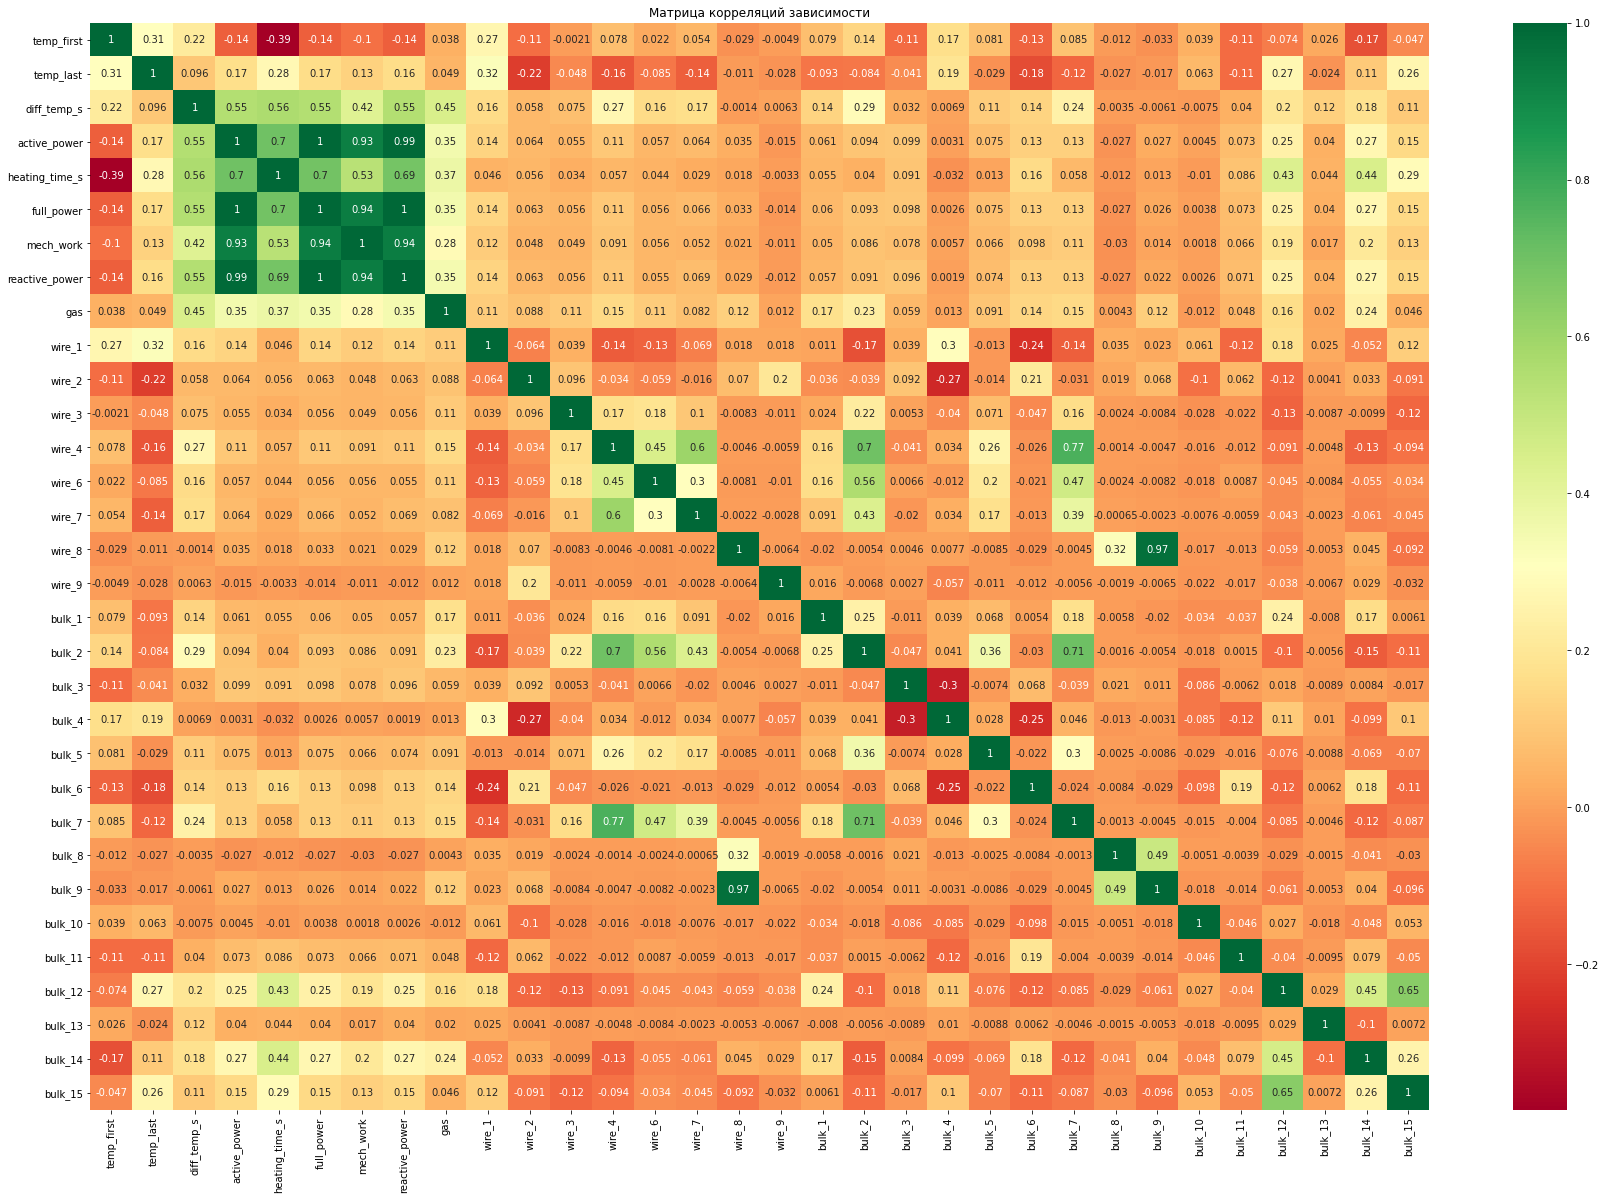

In [147]:
plt.figure(figsize=(30, 20))
plt.title('Матрица корреляций зависимости')
sns.heatmap(data_svot.corr(), annot = True, cmap='RdYlGn')
plt.show()

Посмотрим как признаки вляют на наш target

In [148]:
data_svot.corr()['temp_last']

temp_first        0.305130
temp_last         1.000000
diff_temp_s       0.096280
active_power      0.167437
heating_time_s    0.278361
full_power        0.165647
mech_work         0.129328
reactive_power    0.161634
gas               0.049040
wire_1            0.323203
wire_2           -0.215643
wire_3           -0.048491
wire_4           -0.161486
wire_6           -0.085316
wire_7           -0.138669
wire_8           -0.011177
wire_9           -0.028327
bulk_1           -0.092682
bulk_2           -0.083549
bulk_3           -0.041386
bulk_4            0.189086
bulk_5           -0.029139
bulk_6           -0.184968
bulk_7           -0.124873
bulk_8           -0.026924
bulk_9           -0.016539
bulk_10           0.063357
bulk_11          -0.113183
bulk_12           0.271330
bulk_13          -0.024298
bulk_14           0.109192
bulk_15           0.264235
Name: temp_last, dtype: float64

Посмотрим,какие признаки вляют больше  всего.

In [149]:
data_svot.corr()['temp_last'][data_svot.corr()['temp_last'].abs() >= 0.1].head(6) 

temp_first        0.305130
temp_last         1.000000
active_power      0.167437
heating_time_s    0.278361
full_power        0.165647
mech_work         0.129328
Name: temp_last, dtype: float64

Посмотрим,какие признаки вляют меньше  всего.

In [150]:
data_svot.corr()['temp_last'][data_svot.corr()['temp_last'].abs() <= 0.1] 

diff_temp_s    0.096280
gas            0.049040
wire_3        -0.048491
wire_6        -0.085316
wire_8        -0.011177
wire_9        -0.028327
bulk_1        -0.092682
bulk_2        -0.083549
bulk_3        -0.041386
bulk_5        -0.029139
bulk_8        -0.026924
bulk_9        -0.016539
bulk_10        0.063357
bulk_13       -0.024298
Name: temp_last, dtype: float64

ПО матрице параметров видно, что наши новосозданные признаки имеют прямую зависимость.
Столбцы почти не влияют на конечную тепературу:key,diff_temp_s,gas,wire_3,wire_6,wire_9,bulk_1,bulk_2,bulk_3,bulk_5,bulk_1.
Столбцы влияющие больше всего: temp_first, temp_last, active_power, heating_time_s, full_power, mech_work 

#### Вывод

В данном пункте мы избавились от пропусков, удалили выбросы,добавили новые признаки и обьединили данные в общую таблицу.
Также построили матрицу корреляции параметров, по также имеют зависимось между собой материалы bulk 12 и bulk 15.  
Также зависимость имеют время нагрева с активной мощностью, полная мощность, работой, реактивной мощностью.
Столбцы влияющие больше всего: temp_first, temp_last, active_power, heating_time_s, full_power, mech_work 

Построим графики распределения признаков

In [151]:
col = data_svot.columns.to_list()

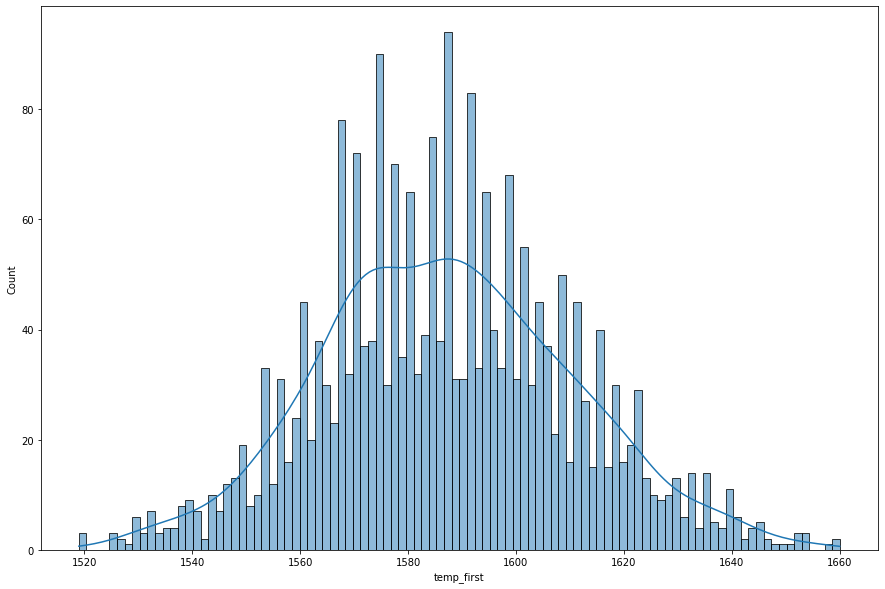

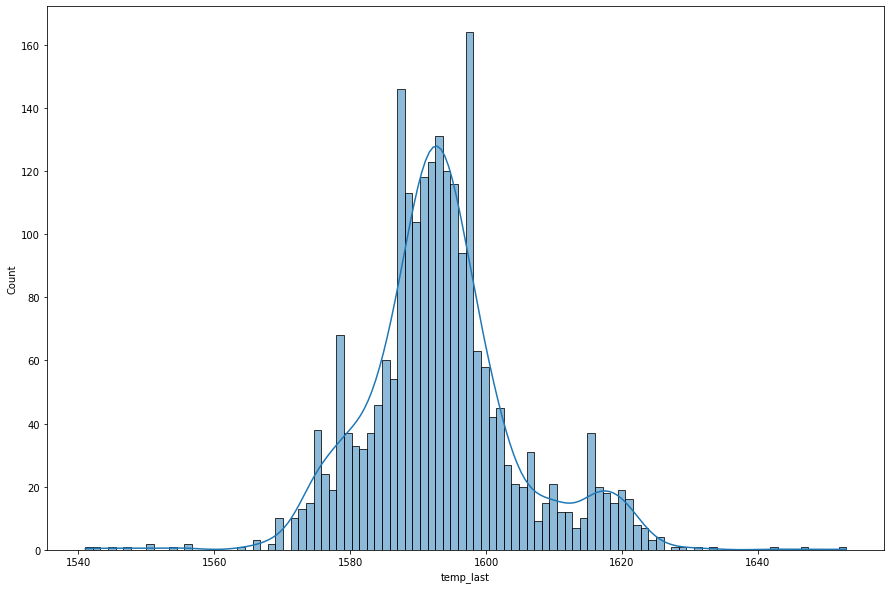

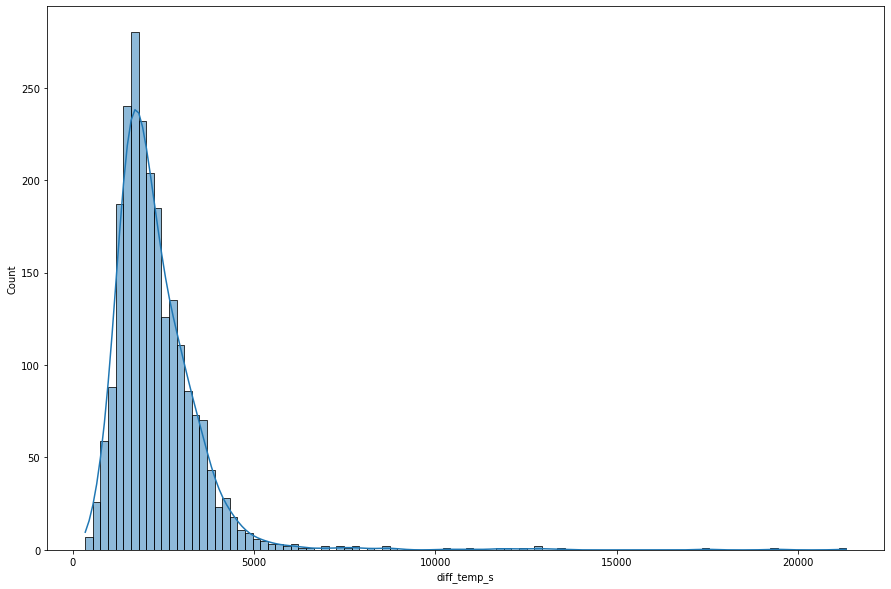

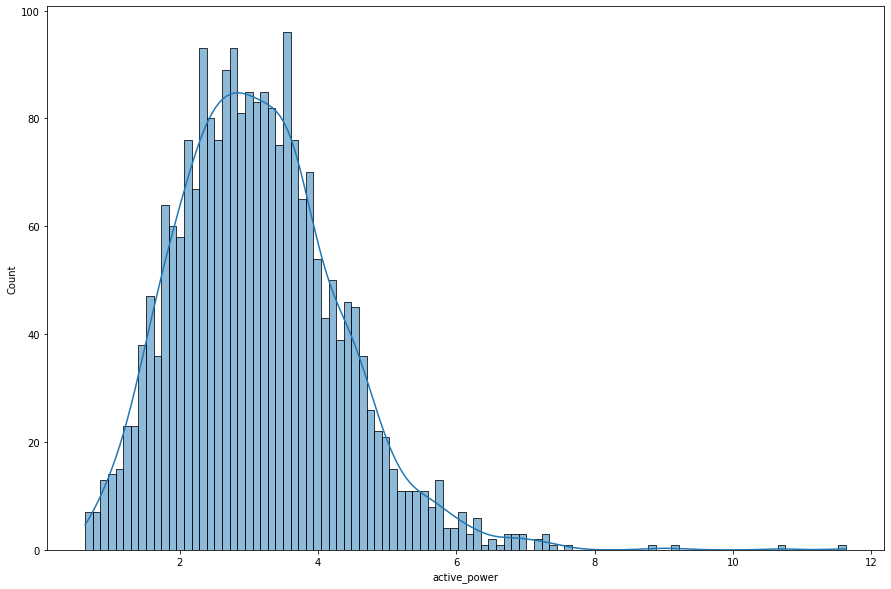

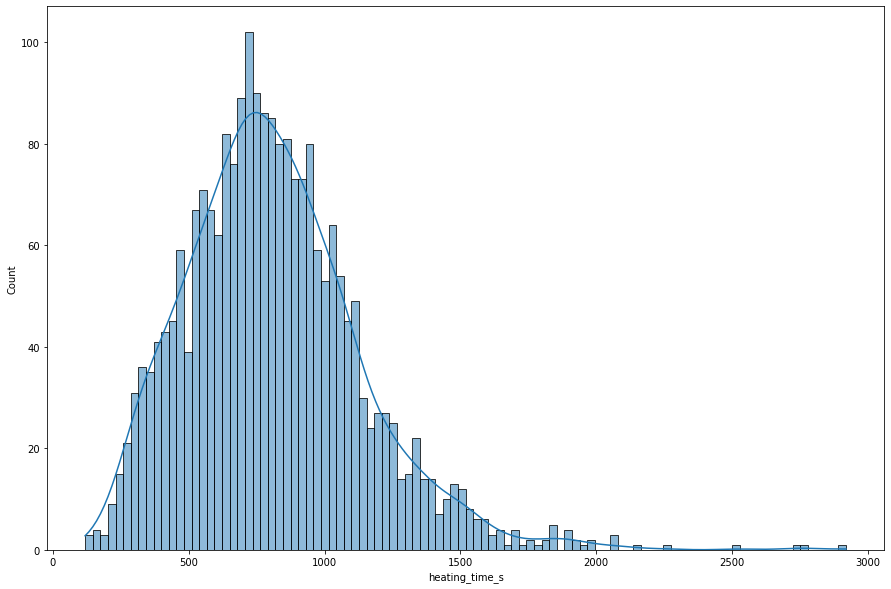

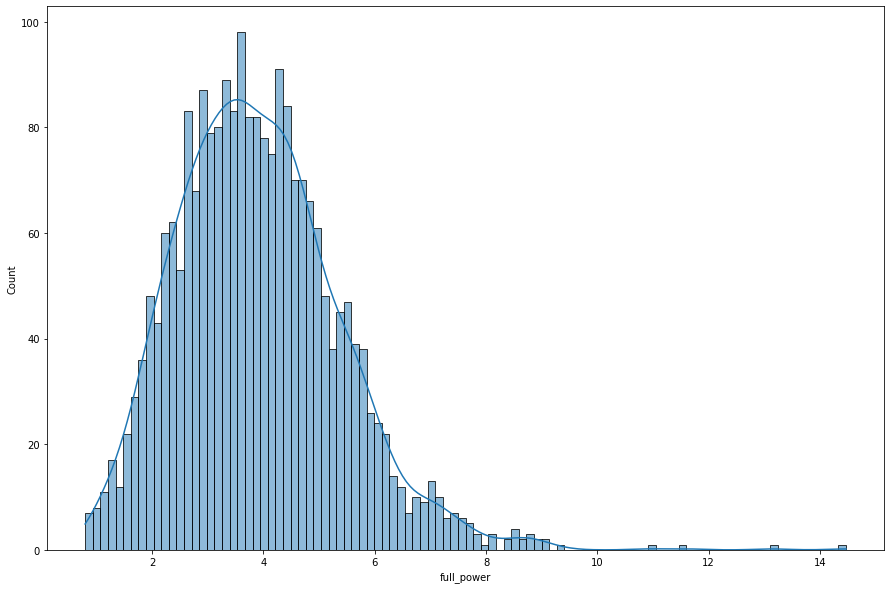

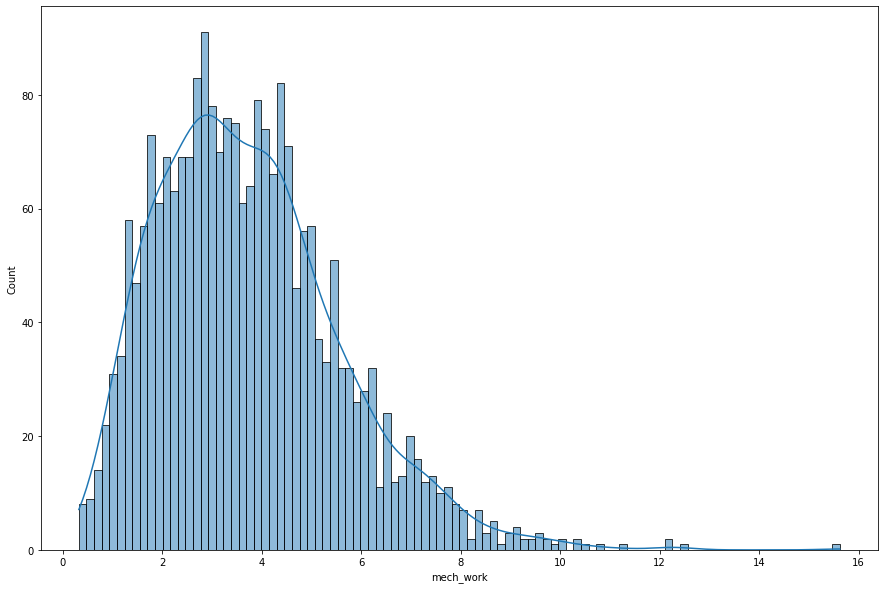

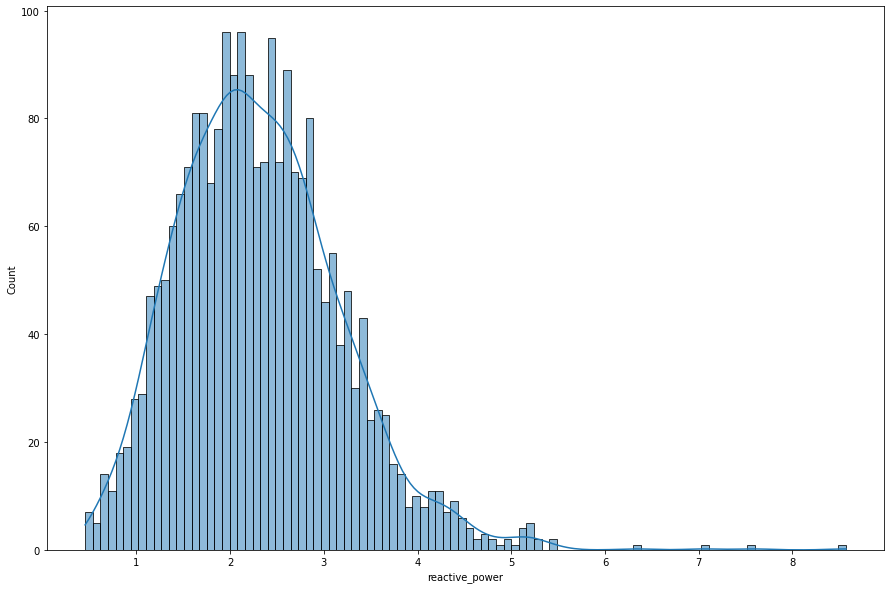

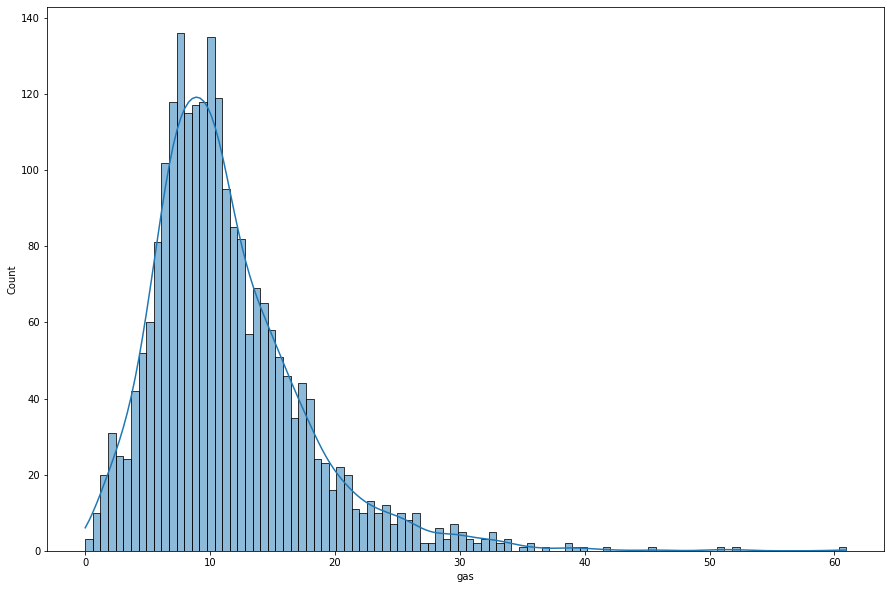

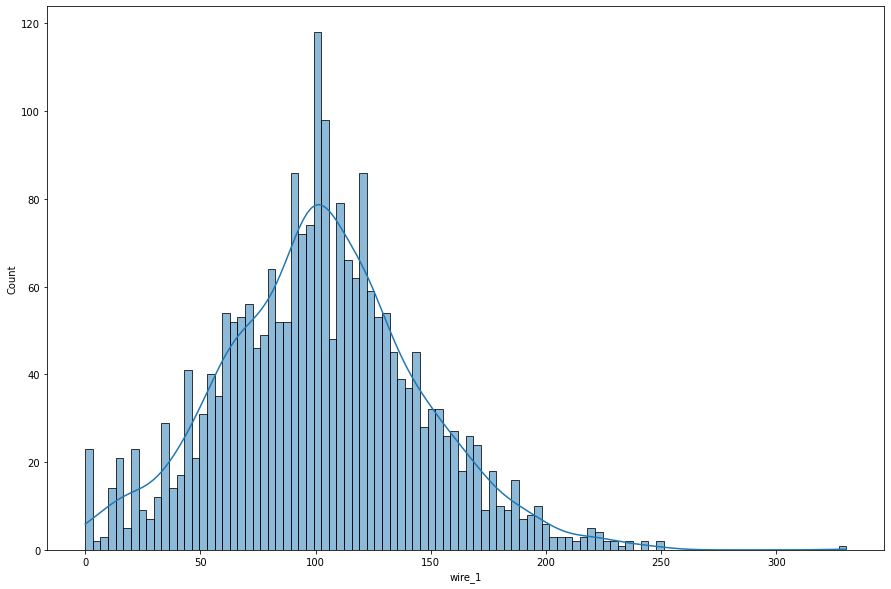

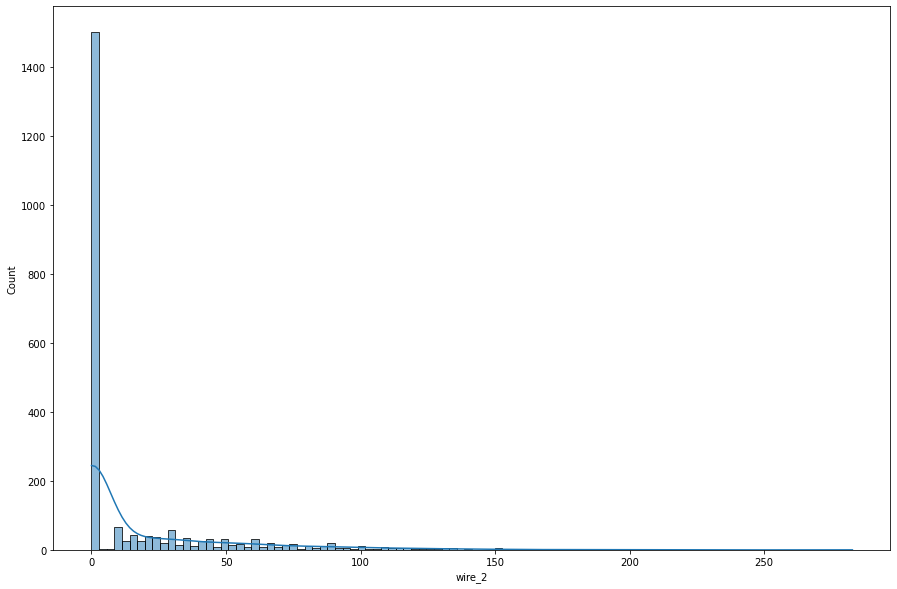

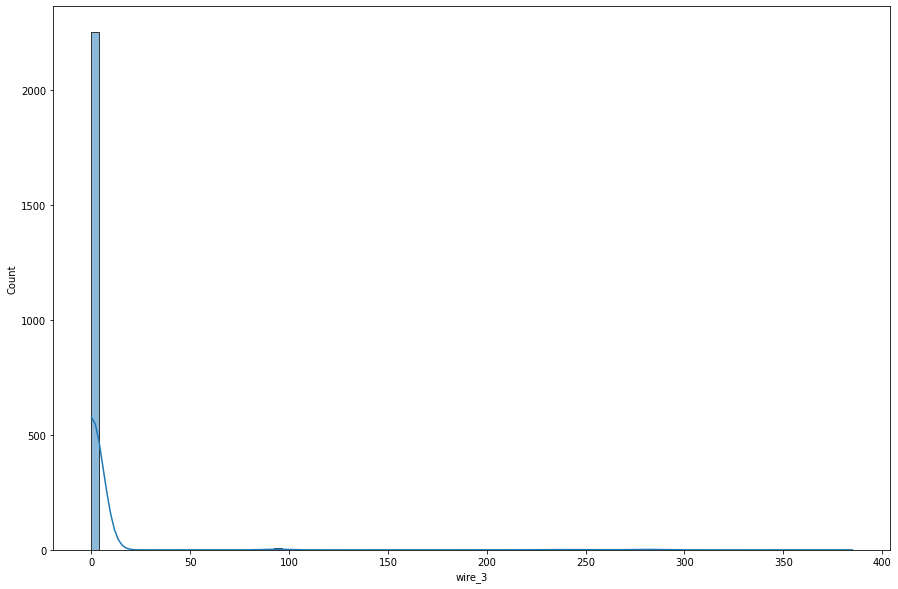

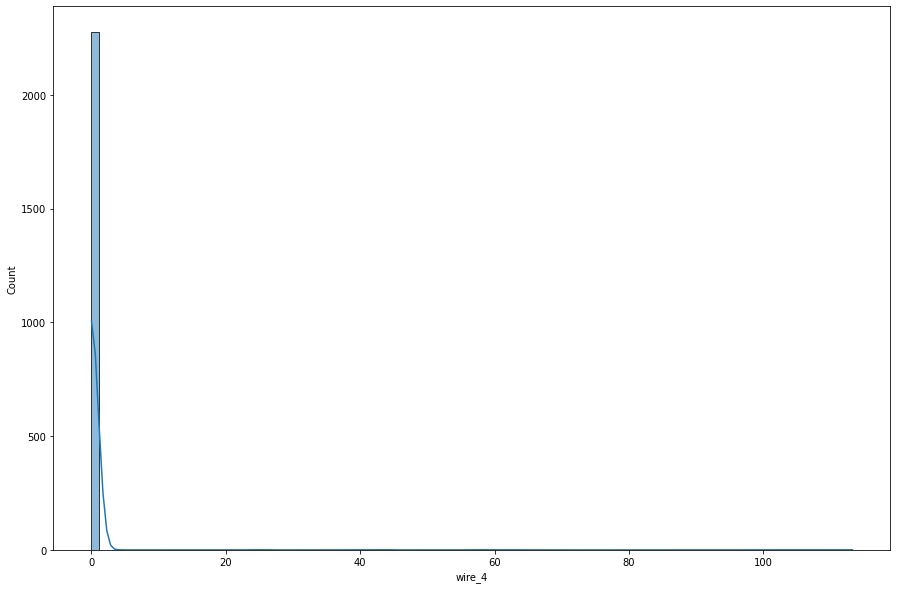

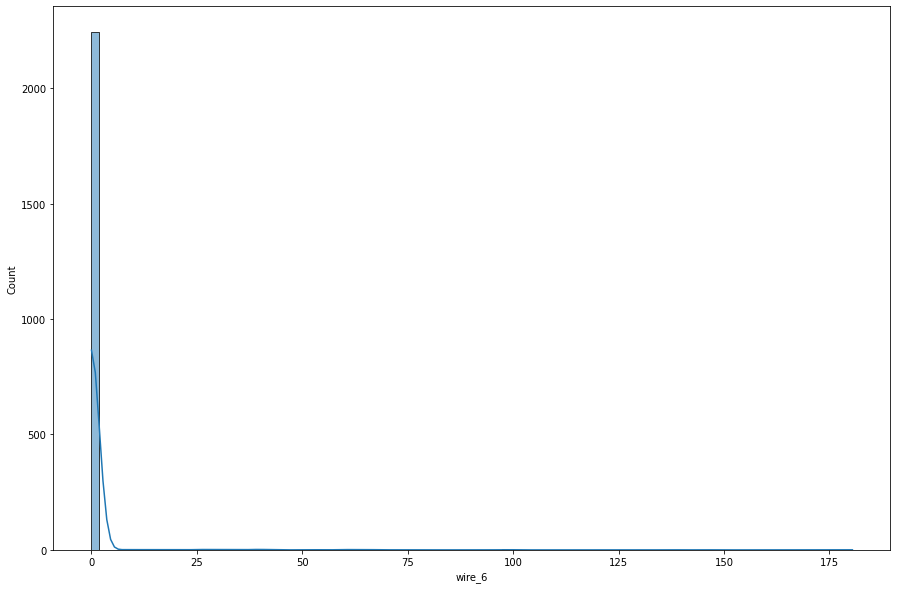

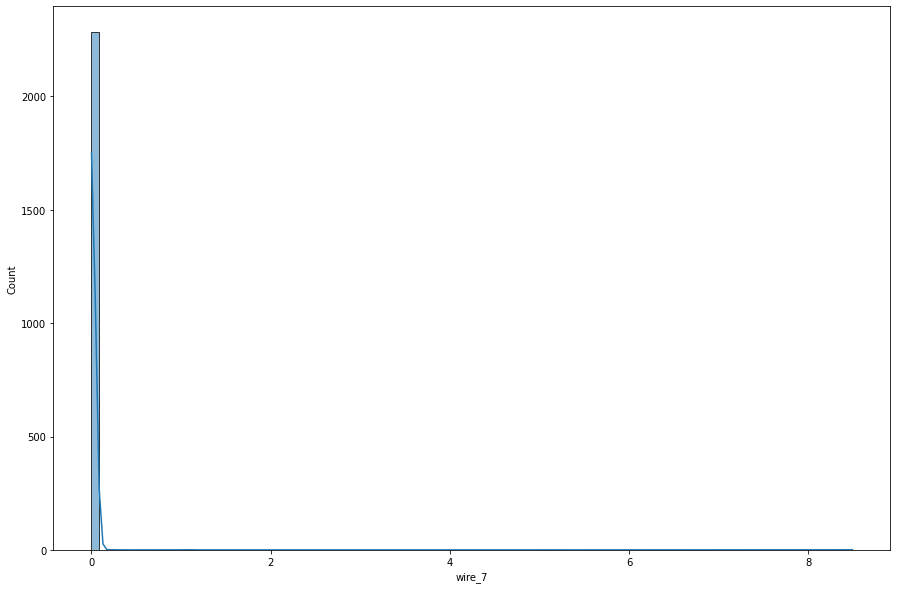

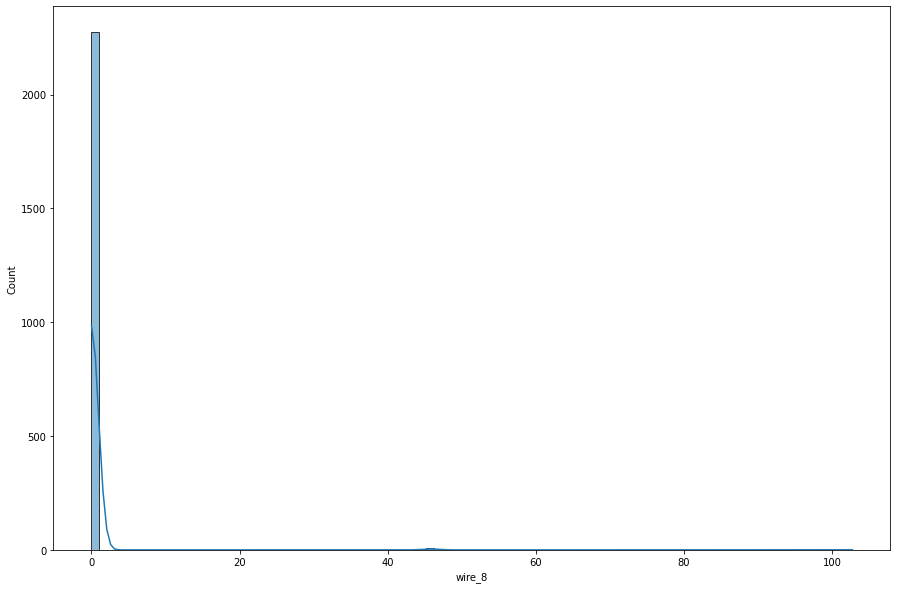

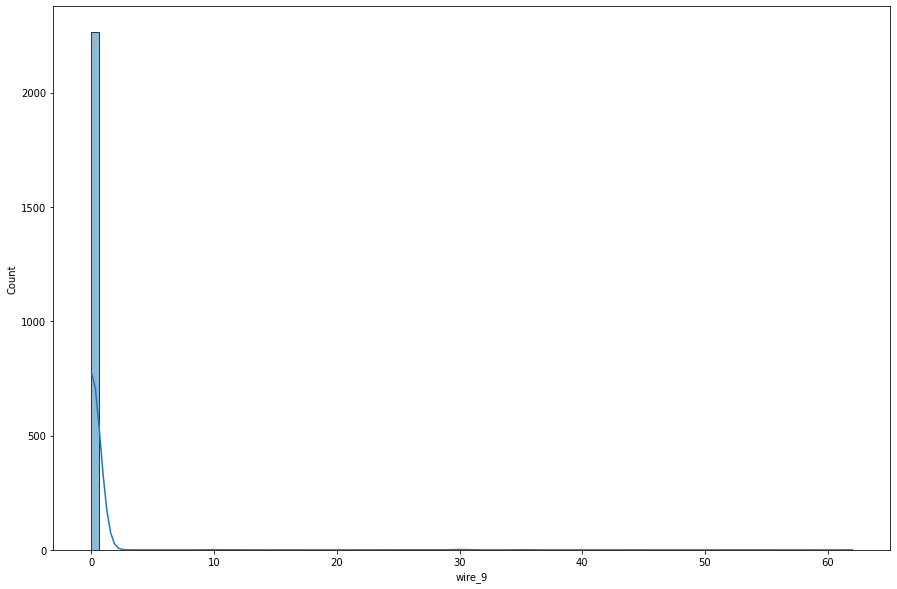

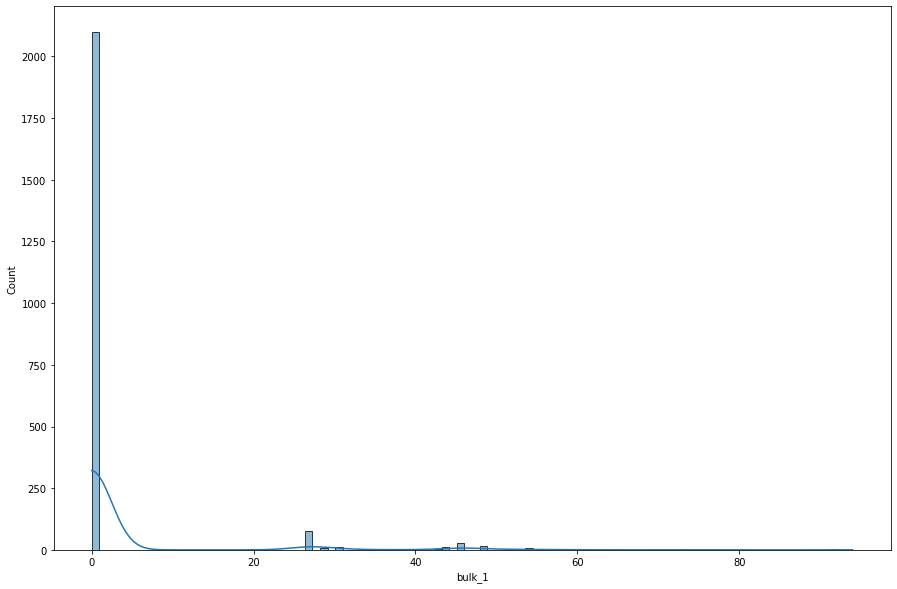

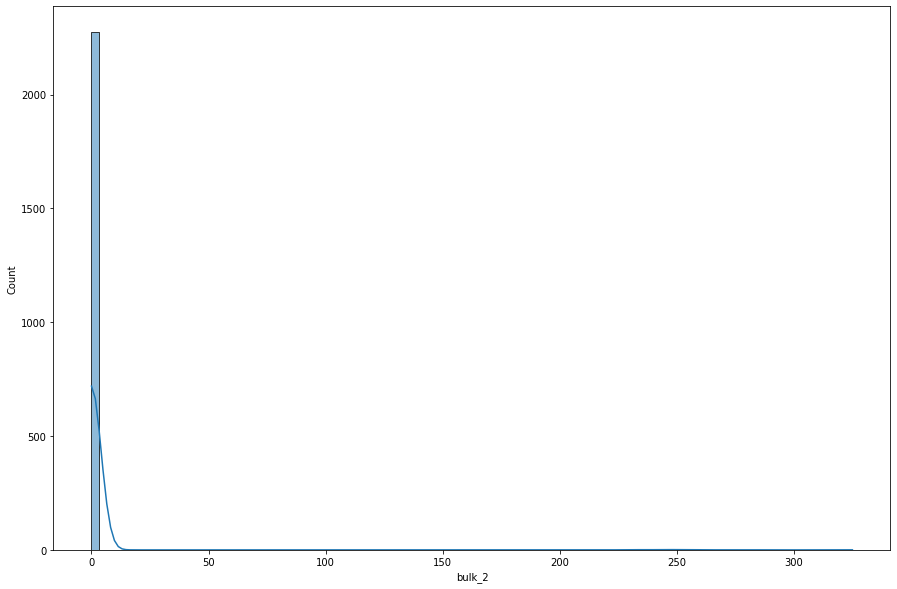

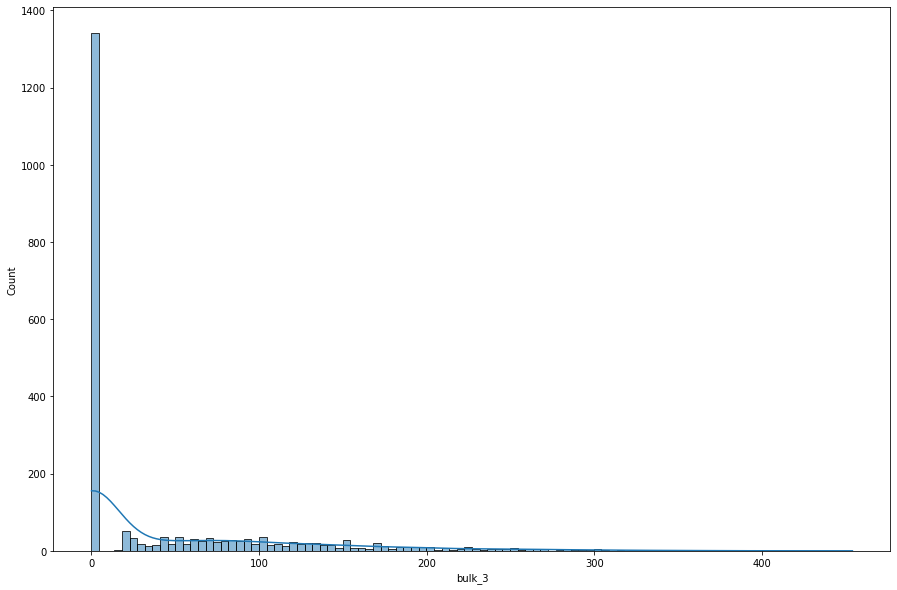

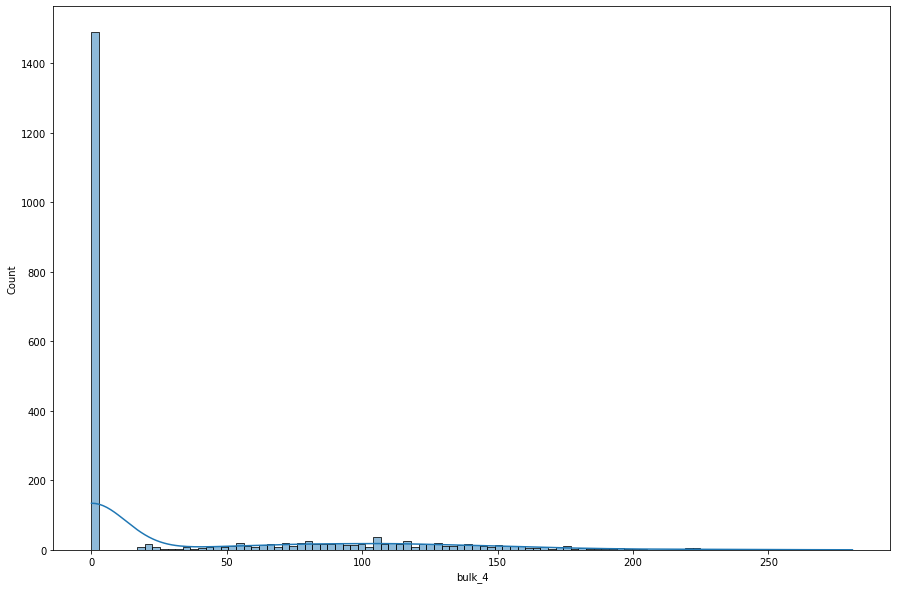

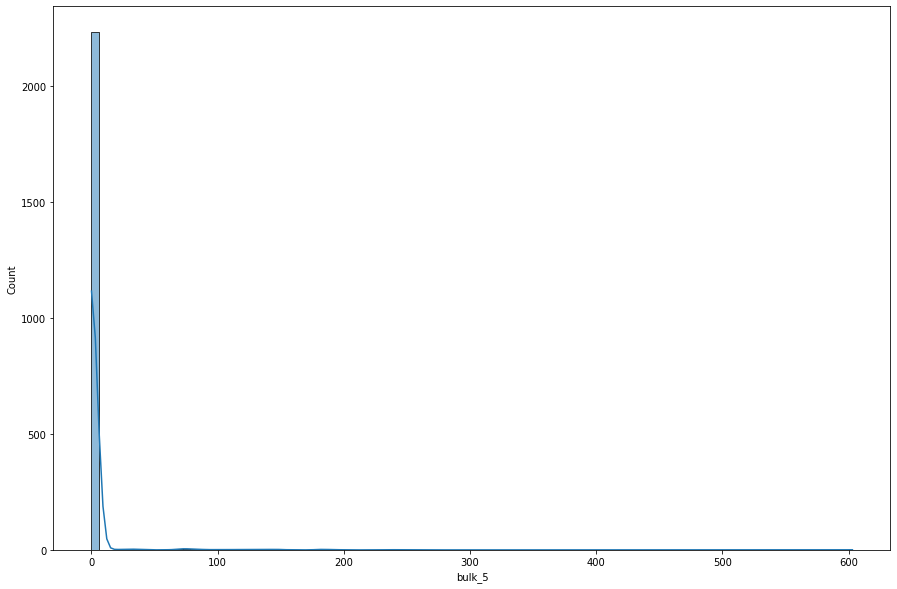

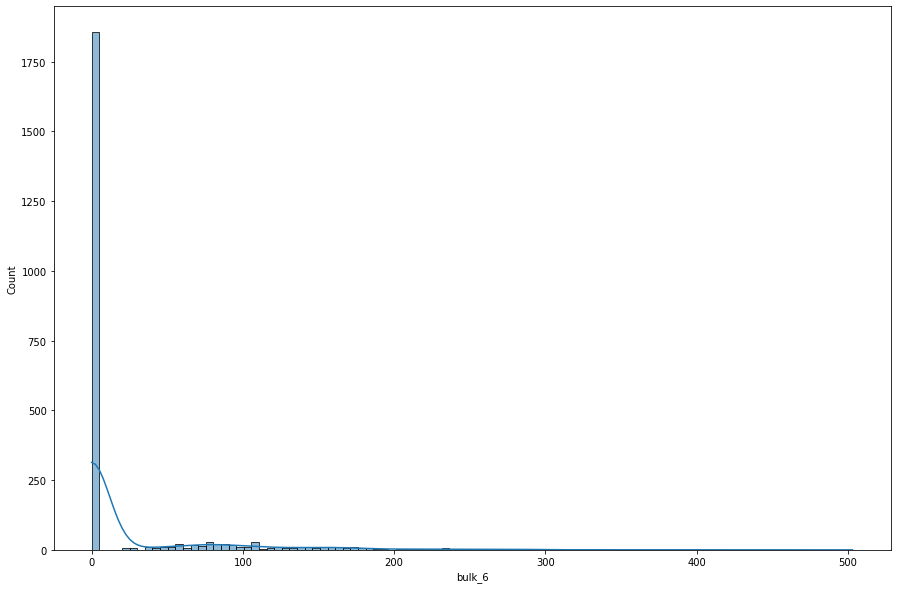

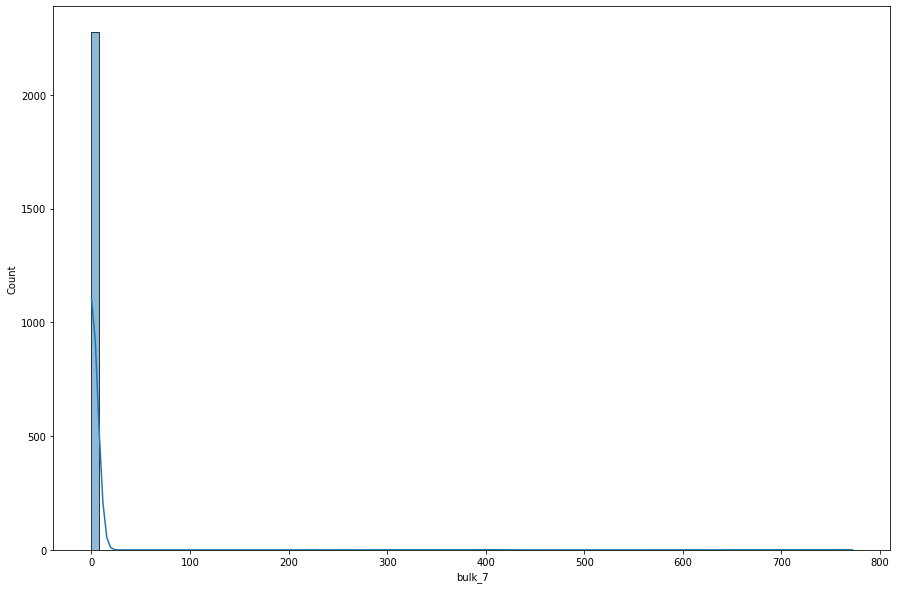

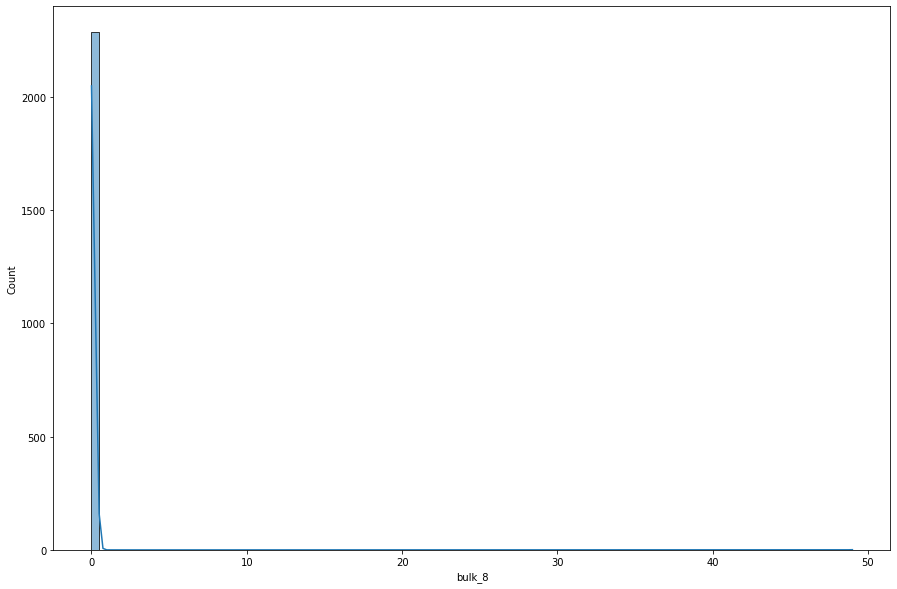

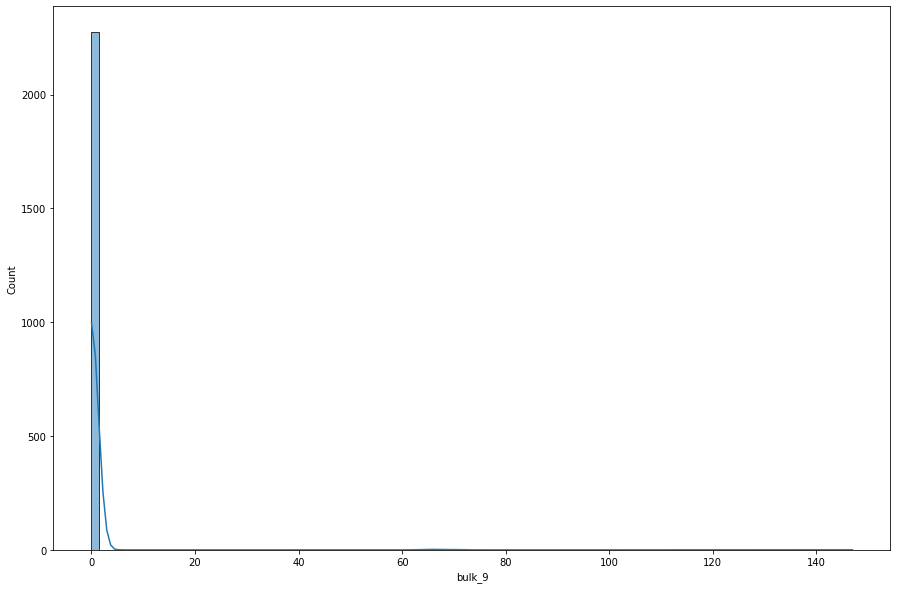

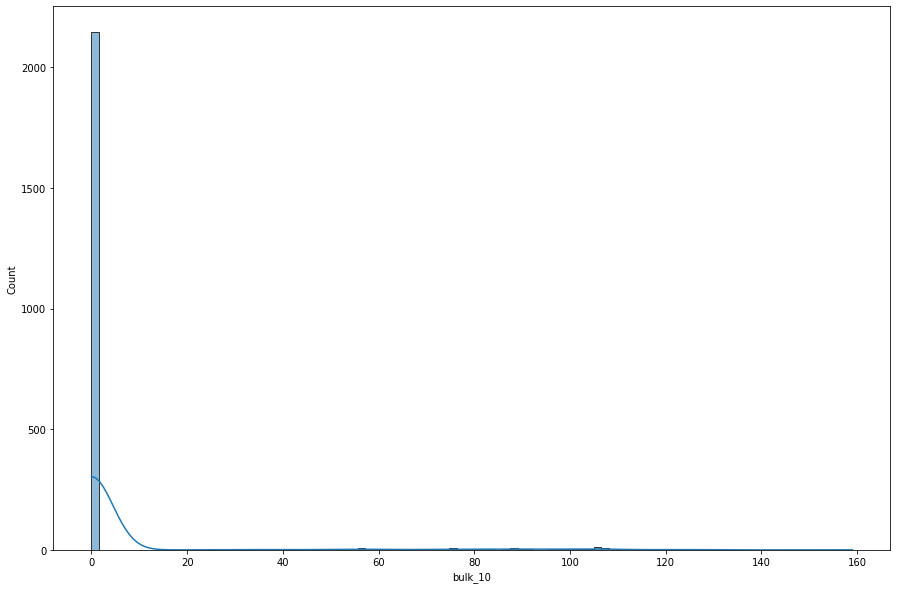

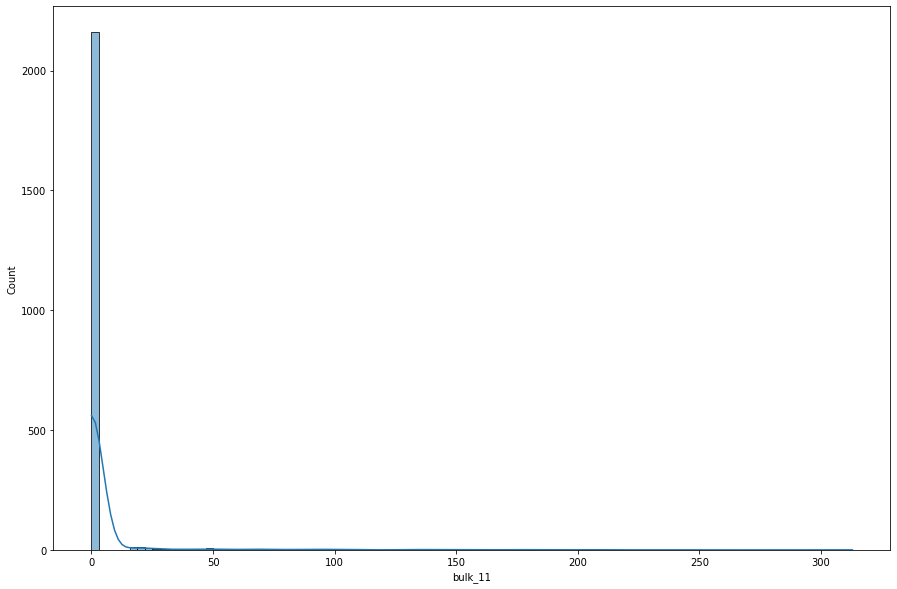

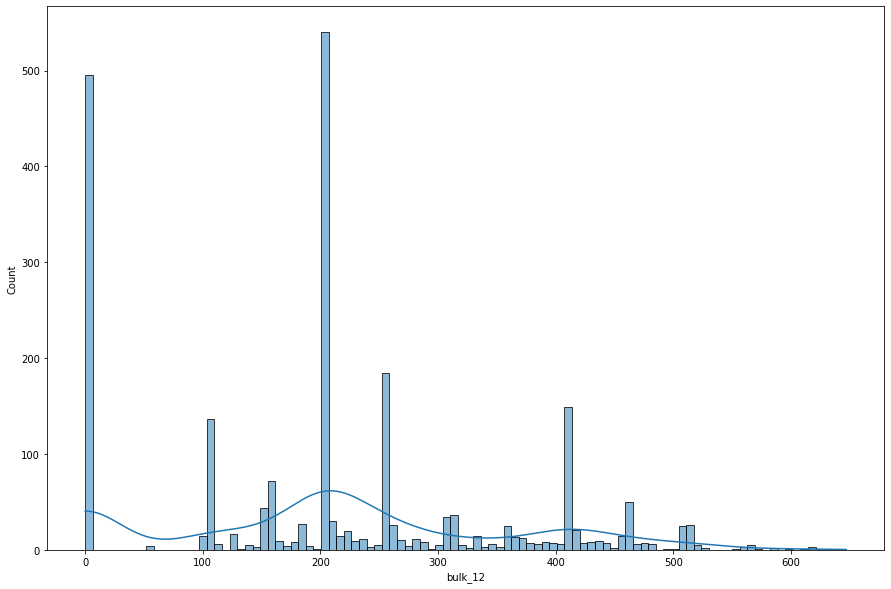

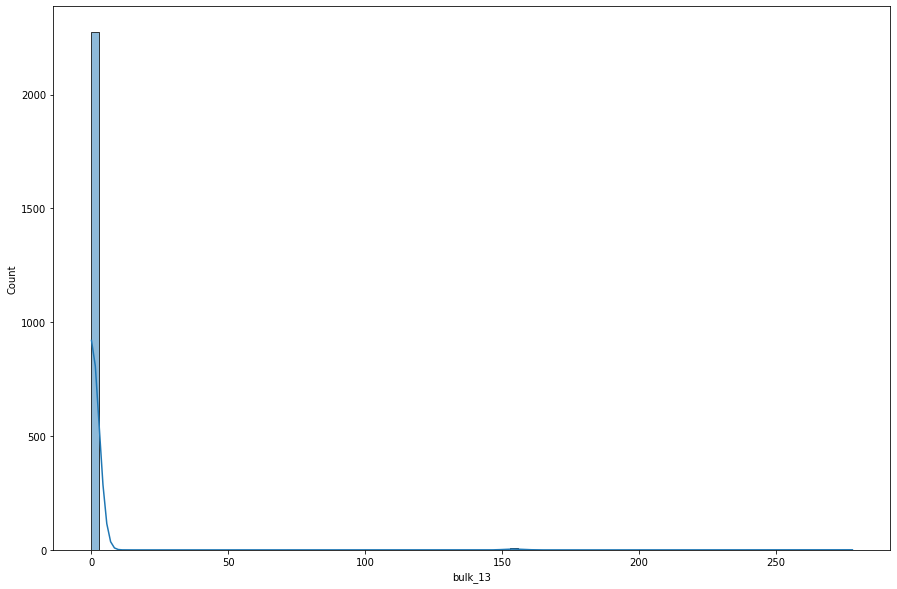

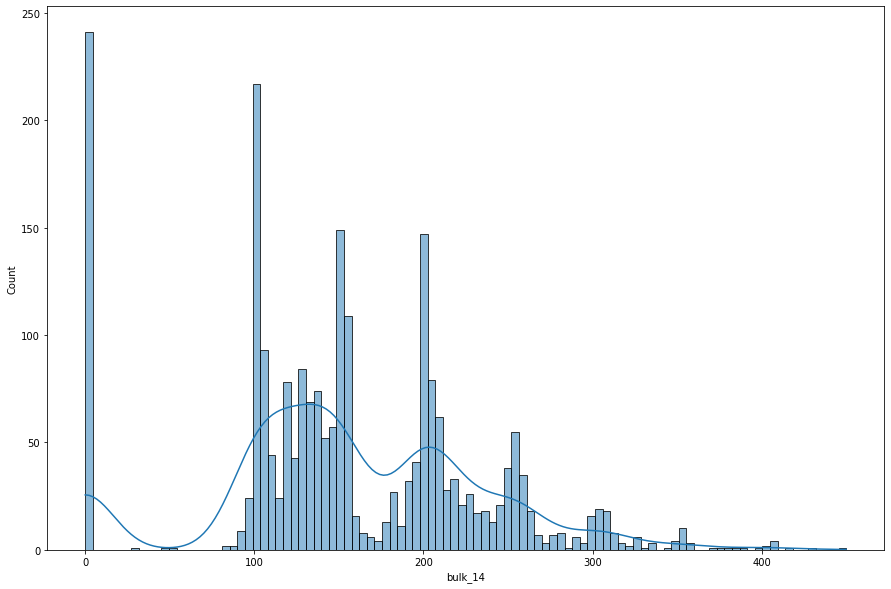

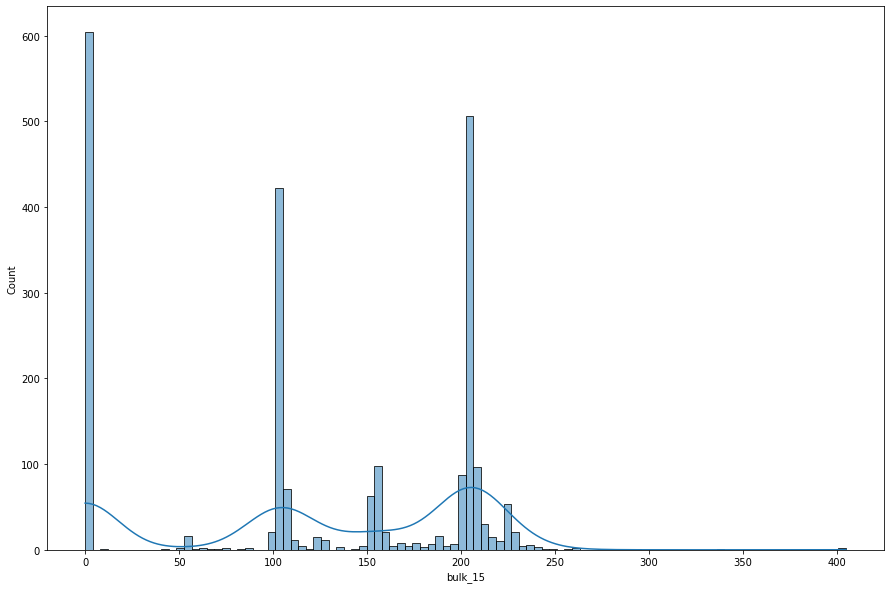

In [146]:
for i in col:
    plt.figure(figsize=(15,10))
    sns.histplot(data_svot[i],kde=True,bins=100)
    plt.show()

ПО графикам видно, что начальная температура, примерно 1500 градусов, как и  конечная.
Время нагрева 750 секунд, чаще всего встречается активная мощность равна 3,реактивная 2,а полная равная 4. Чаще всего в разных количествах добавляют следующие материалы ware_1, bulk 12,14,15

### Обучение модели

#### Разделение данных на обучающую и тестовую выборку

Разобьем данные на train и test к соотношению 75/25

In [147]:
features = data_svot.drop(['temp_last'], axis=1)
target = data_svot['temp_last']

features_train, features_test, target_train, target_test = train_test_split(
                                                            features, 
                                                            target, 
                                                            test_size=0.25, 
                                                            random_state=random_state)

In [148]:
print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(1715, 31)
(572, 31)
(1715,)
(572,)


Для моделирования, рассмотрим несколько моделей:

RandomForestRegressor
LGBMRegressor
CatBoostRegressor

Обучение моделей.

In [149]:
scaler = MinMaxScaler()
scaler.fit(features_train)

MinMaxScaler()

In [150]:
features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)

#### RandomForestRegressor

In [811]:
%%time
param_grid = {'n_estimators': range(61, 321, 20),
              'max_depth':range(6, 32, 4),
              'criterion':['mse']}
start = time()
print('Подбор гиперпараметров...')
print()
model_RF = RandomForestRegressor(random_state=random_state, n_jobs=-1)
search_RF = GridSearchCV(model_RF, param_grid, cv=3, scoring='neg_mean_absolute_error')
search_RF.fit(features_train, target_train)
time_to_fit_rf = time() - start
print('Время обучения %.2f секунд' %time_to_fit_rf)
print("Оценки значений на наборе:")
print()
means = search_RF.cv_results_['mean_test_score']
stds = search_RF.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, search_RF.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1), params))
print()
print('Лучшее значение MAE для случайного леса: {} при значениях гиперпараметров: {}'.format(-search_RF.best_score_, search_RF.best_params_))
R2_rf = search_RF.score(features_train, target_train)
print('r2:', R2_rf)

Подбор гиперпараметров...

Время обучения 434.66 секунд
Оценки значений на наборе:

6.444518 for {'criterion': 'mse', 'max_depth': 6, 'n_estimators': 61}
6.422019 for {'criterion': 'mse', 'max_depth': 6, 'n_estimators': 81}
6.427423 for {'criterion': 'mse', 'max_depth': 6, 'n_estimators': 101}
6.423443 for {'criterion': 'mse', 'max_depth': 6, 'n_estimators': 121}
6.424775 for {'criterion': 'mse', 'max_depth': 6, 'n_estimators': 141}
6.423340 for {'criterion': 'mse', 'max_depth': 6, 'n_estimators': 161}
6.425019 for {'criterion': 'mse', 'max_depth': 6, 'n_estimators': 181}
6.420476 for {'criterion': 'mse', 'max_depth': 6, 'n_estimators': 201}
6.422361 for {'criterion': 'mse', 'max_depth': 6, 'n_estimators': 221}
6.422022 for {'criterion': 'mse', 'max_depth': 6, 'n_estimators': 241}
6.413847 for {'criterion': 'mse', 'max_depth': 6, 'n_estimators': 261}
6.410938 for {'criterion': 'mse', 'max_depth': 6, 'n_estimators': 281}
6.407613 for {'criterion': 'mse', 'max_depth': 6, 'n_estimators': 

In [816]:
R2_rf = search_RF.score(features_train, target_train)
print('r2:', R2_rf)

r2: -2.6827596297474465


Запишем параметры в отдельные переменные

In [817]:
mae_rfr = -search_RF.best_score_
best_param_rfr = search_RF.best_params_

In [818]:
mae_rfr

6.216020194221219

In [819]:
best_param_rfr

{'criterion': 'mse', 'max_depth': 14, 'n_estimators': 301}

#### LGBMRegressor

In [842]:
%%time
param_grid = {'n_estimators': range(159, 220, 20),
              'max_depth':range(4, 10, 2),
              'learning_rate': [0.05, 0.1]}

print('Подбор гиперпараметров...')
print()
start = time()
model_LGBM = lgb.LGBMRegressor(random_state=random_state)
search_LGBM = GridSearchCV(model_LGBM, param_grid, cv=3, scoring='neg_mean_absolute_error')
search_LGBM.fit(features_train, target_train)
time_to_fit_LGBM = time() - start
print('Время обучения %.2f секунд' %time_to_fit_LGBM)
print("Оценки значений на наборе:")
print()
means = search_LGBM.cv_results_['mean_test_score']
stds = search_LGBM.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, search_LGBM.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1), params))
print()
print('Лучшее значение MAE для градиентного бустинга: {} при значениях гиперпараметров: {}'.format(-search_LGBM.best_score_, search_LGBM.best_params_))

Подбор гиперпараметров...

Время обучения 3618.46 секунд
Оценки значений на наборе:

5.994236 for {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 159}
5.995046 for {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 179}
5.991896 for {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 199}
5.989497 for {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 219}
6.070420 for {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 159}
6.072593 for {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 179}
6.080445 for {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 199}
6.098010 for {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 219}
6.078342 for {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 159}
6.089377 for {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 179}
6.096465 for {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 199}
6.100241 for {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 219}
6.017886 for {'learning_rat

In [843]:
mae_LGBM = -search_LGBM.best_score_

In [844]:
best_param_LGBM = search_LGBM.best_params_

In [845]:
mae_LGBM

5.989496801948005

In [846]:
best_param_LGBM

{'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 219}

#### CatBoostRegressor

In [833]:
%%time
param_grid3 = { 'learning_rate': [0.05, 0.1],
        'depth': range(2, 11, 2),'l2_leaf_reg': range(2, 11, 4),
        'iterations'  : range(200, 301, 100)  
       }

print('Подбор гиперпараметров...')
print()
start = time()
model_cats = CatBoostRegressor(random_state=random_state)
search_cats = GridSearchCV(model_cats, param_grid3, cv=3, scoring='neg_mean_absolute_error')
search_cats.fit(features_train, target_train)
time_to_fit_cat = time() - start
print('Время обучения %.2f секунд' %time_to_fit_cat)

print('Лучшее значение MAE для CatBoost: {} при значениях гиперпараметров: {}'.format(-search_cats.best_score_, search_cats.best_params_))

Подбор гиперпараметров...

0:	learn: 10.9188179	total: 56.1ms	remaining: 11.2s
1:	learn: 10.8512265	total: 57.1ms	remaining: 5.65s
2:	learn: 10.7845130	total: 57.8ms	remaining: 3.79s
3:	learn: 10.7112464	total: 58.5ms	remaining: 2.87s
4:	learn: 10.6525008	total: 59.5ms	remaining: 2.32s
5:	learn: 10.5991223	total: 60.5ms	remaining: 1.96s
6:	learn: 10.5197359	total: 61.4ms	remaining: 1.69s
7:	learn: 10.4818174	total: 62.4ms	remaining: 1.5s
8:	learn: 10.4277862	total: 63.4ms	remaining: 1.35s
9:	learn: 10.3516924	total: 64.1ms	remaining: 1.22s
10:	learn: 10.2938611	total: 64.8ms	remaining: 1.11s
11:	learn: 10.2459239	total: 65.5ms	remaining: 1.03s
12:	learn: 10.1801427	total: 66.2ms	remaining: 952ms
13:	learn: 10.1298331	total: 66.9ms	remaining: 889ms
14:	learn: 10.0943085	total: 67.6ms	remaining: 834ms
15:	learn: 10.0613048	total: 68.3ms	remaining: 785ms
16:	learn: 10.0068001	total: 69ms	remaining: 742ms
17:	learn: 9.9759798	total: 69.7ms	remaining: 705ms
18:	learn: 9.9414831	total: 70.4m

In [838]:
mae_cats = -search_cats.best_score_

In [839]:
best_param_cats = search_cats.best_params_

In [840]:
mae_cats

5.873213464713491

In [841]:
best_param_cats

{'depth': 6, 'iterations': 300, 'l2_leaf_reg': 2, 'learning_rate': 0.05}

#### Сводная таблица по обучению

In [849]:
res = ['RandomForestRegressor', 'LGBMRegressor', 'CatBoostRegressor']

result = [
    {'Время обучения сек.' : time_to_fit_rf,  'MAE':mae_rfr},
    {'Время обучения сек.' : time_to_fit_LGBM,  'MAE':mae_LGBM},
    {'Время обучения сек.' : time_to_fit_cat,  'MAE':mae_cats},
]

result_table = pd.DataFrame(result, index=res)
result_table

Время обучения сек.       MAE
RandomForestRegressor           434.663229  6.216020
LGBMRegressor                  3618.455929  5.989497
CatBoostRegressor               713.771277  5.873213

#### Вывод:

В данном раздели мы рассмотрели три модели для предсказания финальной температуры. Лучшей моделью стала CatBoostRegressor со следующими параметрами {'depth': 6, 'iterations': 300, 'l2_leaf_reg': 2, 'learning_rate': 0.05} и значением Мае = 5.873213464713491

### Тестирование модели:

Рассмотрим константную модель

In [151]:
dummy = DummyRegressor(strategy='mean').fit(features_train, target_train)
dummy_pred = dummy.predict(features_test)
print('Mae: ', mean_absolute_error(target_test, dummy_pred))

Mae:  8.156629085200523


Наша модель предсказывает лучше случайной

Протестируем лучшую на модель 

In [851]:
predicted = search_cats.predict(features_test)
mae = mean_absolute_error(target_test, predicted)
print('MAE:', mae)

MAE: 5.652788996308059


Выбраная модель достигает значения < 6 даже на тестовой выборке

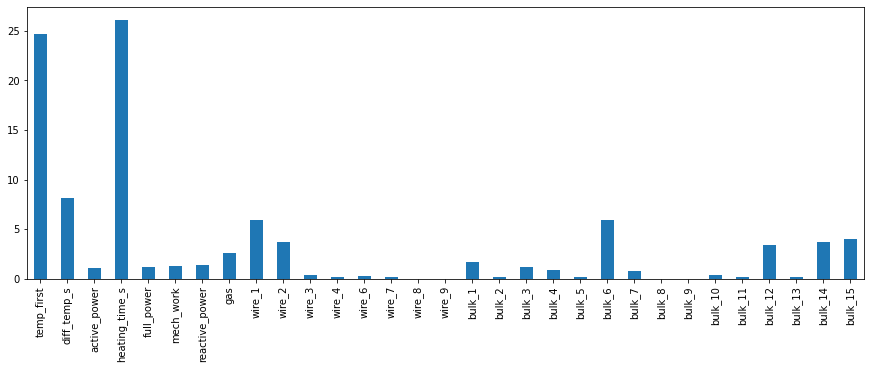

In [852]:
cats = pd.Series(search_cats.best_estimator_.feature_importances_, index=features.columns)

plt.figure(figsize=(15,5))
cats.plot.bar()
plt.show()

Больше всего на конечную температуру влияют время нагрева и начальная тепература

#### Вывод

В данном раздели мы рассмотрели константную модель и сравнили ее с выбранной, убедились в том, что выбранная нами модель предсказывает лучше случайной. На тестовой выборке модель показывает результат, что удовлетворяет требования. Из графика важности параметров видно, что на конечный результат больше всего влияют, следующий параметры: temp_first и  heating_time_s

### Итоговый вывод

В данной работе перед нами стояла задача построить модель, которая предскажет температуру стали.
В ходе выполнения данной задачи были обработаны и подготовлены данные для работы с моделями. В имеющихся данным было много пропущенных значений, связанно это с отсутствием применения материала или измерений, данные отсутствующие значения мы заполнили нулями. В ходе работы все имеющийся таблицы были сгруппированы по ключи в единую таблицу.
В нее попали партий, у которых температура измерялась более одного раза. При работе с моделями для первичного тестирования были выбраны следующие модели: 'RandomForestRegressor', 'LGBMRegressor', 'CatBoostRegressor'. В ходе работы требуемого значения МАЕ < 6 достигли 2 модели 'LGBMRegressor', 'CatBoostRegressor'. 
Лучшие из этих моделей оказалась модель CatBoostRegressor со следующими параметрами:{'depth': 4, 'iterations': 300, 'l2_leaf_reg': 2, 'learning_rate': 0.1}. Результаты данной модели  на тренировочной 5.898415284919262 и тестовой выборке 5.652788996308059. Значения МАЕ удовлетворяют значению < 6, значит поставленная перед нами задача выполнена.
Этот результат показывает, что модель в среднем ошибается на 5,5-6 градусов температуры. Что при температуре свыше 1500 градусов, составляет 0,4%. 
Можно сделать вывод, что модель точно предсказывает температуру и ее можно использовать в работе.